In [277]:
# required imports
from vivarium.plots.simulation_output import _save_fig_to_dir as save_fig_to_dir
import ast
import cobra
from cobra import io
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from vivarium.plots.topology import plot_topology

In [278]:
# Define the path to the SBML model file
model_path = "../vivarium_microbiome/data/Alteromonas_Model.xml"
#model_path = "../vivarium_microbiome/data/e_coli_core.xml"

In [279]:
# Load the model
model = io.read_sbml_model(model_path)

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


In [280]:
# 1. Number of all reactions
total_reactions = len(model.reactions)
print(f"Total number of reactions: {total_reactions}")

Total number of reactions: 881


In [281]:
# 2. Number of exchange fluxes
exchange_reactions = [reaction for reaction in model.reactions if reaction.id.startswith('EX_')]
num_exchange_fluxes = len(exchange_reactions)
print(f"Number of exchange fluxes: {num_exchange_fluxes}")

Number of exchange fluxes: 62


In [282]:
# Extract and print human-friendly information for exchange reactions
exchange_reactions = [reaction for reaction in model.reactions if reaction.id.startswith('EX_')]
print("Human-friendly exchange reactions information:")
for reaction in exchange_reactions:
    # Format the bounds in a readable way
    bounds = f"[{reaction.lower_bound}, {reaction.upper_bound}]"
    
    # Print the details
    #print(f"ID: {reaction.id}, Name: {reaction.name}, Bounds: {bounds}")

Human-friendly exchange reactions information:


In [283]:
# Optional: Specify the reaction ID for which you want to find the name
reaction_id_to_find = "EX_cpd00033_e0"

# Find the reaction by its ID and print its name
for reaction in model.reactions:
    if reaction.id == reaction_id_to_find:
        print(f"The name of the reaction with ID '{reaction_id_to_find}' is: '{reaction.name}'")
        break
else:
    print(f"No reaction found with the ID '{reaction_id_to_find}'")

The name of the reaction with ID 'EX_cpd00033_e0' is: 'Exchange for Glycine_e0'


In [284]:
# Optional: Dictionary for exchange fluxes: ID as key, Name as value
name_exchange_fluxes_dict = {reaction.id: reaction.name for reaction in model.reactions if reaction.id.startswith('EX_')}

#print(name_exchange_fluxes_dict)

In [285]:
# Dictionary for exchange fluxes: ID as key, Bounds as value
bound_exchange_fluxes_dict = {reaction.id: f"[{reaction.lower_bound}, {reaction.upper_bound}]" 
                        for reaction in model.reactions if reaction.id.startswith('EX_')}

# Adding an empty key and value
new_key = "None"  # This is an example key. 
bound_exchange_fluxes_dict[new_key] = "None"

# Print the dictionary
#print(bound_exchange_fluxes_dict)

In [286]:
# Import the FBA class and the main function from the Fba_process.py file
sys.path.append('../vivarium_microbiome/processes/Altrmns/')
from Fba import FBA, main

In [287]:
# Function to process model with setting the bound to a given flux_id as zero
def process_model(model_path, flux_id, flux_name):
    if flux_id == "None":
        output, processes, topology = main(model_path)
    else:
        reaction_id = flux_id  # Assuming the key itself is the reaction ID
        bounds = [0, 0]  # Set bounds to zero
        output, processes, topology = main(model_path, reaction_id, bounds)
        print(f"Set {flux_name} as zero. Flux ID: {flux_id}")

    return output

In [288]:
# Function to extract flux data from output
def extract_flux_data(output):
    if isinstance(output, str):
        output = ast.literal_eval(output)
    flux_data = output[1]['fluxes_values']
    return flux_data

In [289]:
# Function to sort and print flux details
def sort_and_print_fluxes(flux_data, flux_type):
    sorted_fluxes = sorted(flux_data.items(), key=lambda item: item[1])
    num_fluxes = len(sorted_fluxes)
    print(f"Number of {flux_type} Fluxes: {num_fluxes}")

    print(f"\n{flux_type} Fluxes:")
    for key, value in sorted_fluxes:
        print(f'{key}: {value}')

In [290]:
def ex_bar_chart(flux_data, flux_name, ex_output_folder, 
                 bar_colors, objective_flux, objective_flux_label, is_in_original_uptake_list):

    sorted_fluxes = sorted(flux_data.items(), key=lambda item: item[0])
    keys, values = zip(*sorted_fluxes)

    plt.figure(figsize=(12, 6))

    # Plot the regular flux bars
    plt.bar(keys, values, color=bar_colors)

    # Add a white (or transparent) bar for spacing
    plt.bar(len(keys), 0, color='white', width=0.5)

    # Add the objective flux bar separately at the end, in red
    plt.bar(len(keys) + 1, objective_flux, color='red', width=0.5)

    plt.xlabel('Exchange Fluxes')
    plt.ylabel('Flux Value')
    plt.title(f'Exchange Fluxes when {flux_name} is zero')
    plt.xticks(list(range(len(keys) + 2)), list(keys) + ['', objective_flux_label], rotation=90)

    plt.tight_layout()
    uptake_prefix = "up_" if is_in_original_uptake_list else ""
    file_name = f"{uptake_prefix}Ex_{flux_name}_zero_with_objective.png"

    file_path = os.path.join(ex_output_folder, file_name)
    plt.savefig(file_path)
    plt.close()


In [291]:
def calculate_flux_changes(current_flux_dict, original_flux_dict):
    difer_flux_dict = {}
    for flux_id, current_flux in current_flux_dict.items():
        original_flux = original_flux_dict.get(flux_id, 0)
        if original_flux != 0:
            change = abs(current_flux - original_flux) / abs(original_flux)
            difer_flux_dict[flux_id] = change
    return difer_flux_dict

In [292]:
def plot_top_flux_changes(difer_flux_dict, top_n=20):
    # Sort and get the top N changes
    sorted_changes = sorted(difer_flux_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    # Extract IDs and values for plotting
    flux_ids, changes = zip(*sorted_changes)

    plt.figure(figsize=(10, 6))
    plt.bar(flux_ids, changes, color='brown')
    plt.xlabel('Flux ID')
    plt.ylabel('Normalized Flux Change')
    plt.title(f'Top {top_n} Flux Changes')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [299]:
def main_loop(model_path, bound_exchange_fluxes_dict, name_exchange_fluxes_dict, ex_output_folder):
    # Initialize the dictionary and list to store the original flux data
    original_flux_dict = {}
    all_flux_changes = {}
    original_uptake_list = []

    # First run with flux_id == "None" to populate original_uptake_list
    output = process_model(model_path, "None", "No Reaction")
    flux_data = extract_flux_data(output)
    original_flux_dict = flux_data
    uptake_fluxes = {key: value for key, value in flux_data.items() if key.startswith('EX_') and value < 0}
    original_uptake_list = list(uptake_fluxes.keys())

    # Now iterate over the other flux IDs
    for flux_id, _ in bound_exchange_fluxes_dict.items():
        if flux_id == "None":
            continue  # Skip the None case as it's already handled

        flux_name = name_exchange_fluxes_dict.get(flux_id, "No Reaction")
        output = process_model(model_path, flux_id, flux_name)
        flux_data = extract_flux_data(output)
        
        
        # Calculate and store the flux changes
        difer_flux_dict = calculate_flux_changes(flux_data, original_flux_dict)
        for key, value in difer_flux_dict.items():
            if key in all_flux_changes:
                all_flux_changes[key] = max(all_flux_changes[key], value)
            else:
                all_flux_changes[key] = value

        # Check if the current flux_id is in original_uptake_list
        is_in_original_uptake_list = flux_id in original_uptake_list

        # Extract exchange, uptake, and secretion fluxes
        exchange_fluxes = {key: value for key, value in flux_data.items() if key.startswith('EX_')}
        uptake_fluxes = {key: value for key, value in exchange_fluxes.items() if value < 0}
        secretion_fluxes = {key: value for key, value in exchange_fluxes.items() if value > 0}
        
        
        # Sort and print fluxes
        sort_and_print_fluxes(uptake_fluxes, "Uptake")
        sort_and_print_fluxes(secretion_fluxes, "Secretion")

        # If output is a string, convert it to a dictionary
        if isinstance(output, str):
            output = ast.literal_eval(output)
        objective_flux = output[1]['objective_flux_value']
        print(f"Objective flux for when eliminate '{flux_id}' ({flux_name}): {objective_flux}")

        bar_colors = ['orange' if objective_flux <= 0 else 'blue' for _ in flux_data]
        
        # Call the bar chart function with the necessary parameters
        ex_bar_chart(exchange_fluxes, flux_name, ex_output_folder, bar_colors, objective_flux, "Objective Flux", is_in_original_uptake_list)
        # After completing the loop, plot the top 20 flux changes
        plot_top_flux_changes(all_flux_changes)



# Specify the ex_output folder
ex_output_folder = "/Users/amin/Desktop/Microbiome/vivarium_microbiome/output/ex"

# Ensure the ex_output folder exists
os.makedirs(ex_output_folder, exist_ok=True)


ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: f90ab928-9972-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:17
Completed in 0.065684 seconds


ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: f995f966-9972-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:18
Completed in 0.041442 seconds
Set Exchange for Cu2+_e0 as zero. Flux ID: EX_cpd00058_e0
Number of Uptake Fluxes: 4

Uptake Fluxes:
EX_cpd00033_e0: -1.4761506276150624
EX_cpd00027_e0: -0.527196652719665
EX_cpd00054_e0: -0.15815899581589965
EX_cpd00067_e0: -0.10543933054393466
Number of Secretion Fluxes: 4

Secretion Fluxes:
EX_cpd00075_e0: 0.15815899581589962
EX_cpd00001_e0: 0.4744769874476987
EX_cpd00047_e0: 0.6853556485355647
EX_cpd00161_e0: 1.4761506276150627
Objective flux for when eliminate 'EX_cpd00058_e0' (Exchange for Cu2+_e0): 0.0


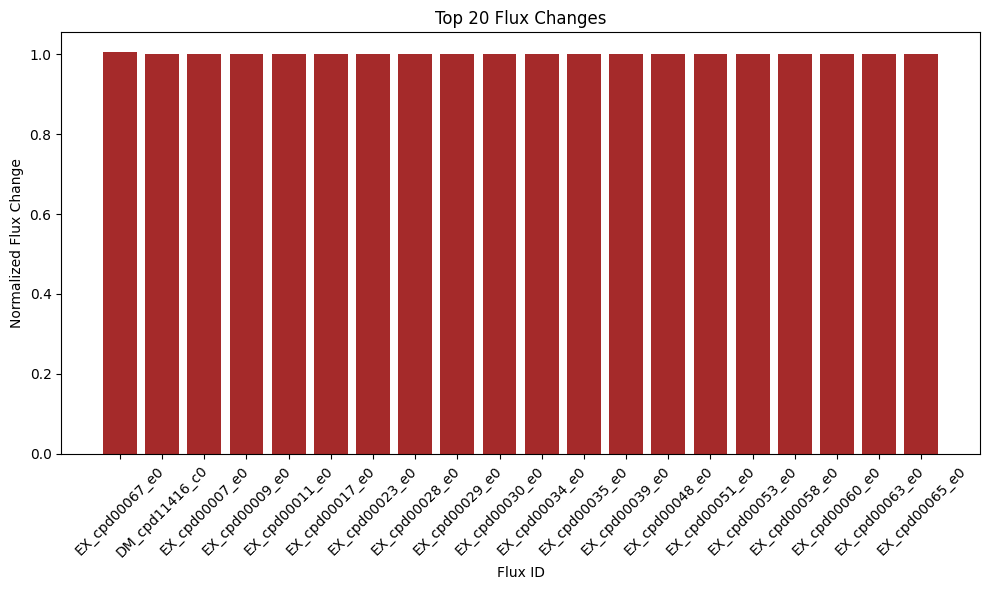

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: faef858e-9972-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:21
Completed in 0.065022 seconds
Set Exchange for L-Tryptophan_e0 as zero. Flux ID: EX_cpd00065_e0
Number of Uptake Fluxes: 38

Uptake Fluxes:
EX_cpd00132_e0: -991.1825410742846
EX_cpd00023_e0: -738.2145057703125
EX_cpd00027_e0: -567.5722340325143
EX_cpd00033_e0: -264.4822258024725
EX_cpd00007_e0: -213.74360293601669
EX_cpd00009_e0: -62.99524914689372
EX_cpd00107_e0: -29.102502573094835
EX_cpd00156_e0: -27.307330409629852
EX_cpd00142_e0: -26.549992073034318
EX_cpd00039_e0: -22.128949168865653
EX_cpd00054_e0: -19.986556548288156
EX_cpd00051_e0: -19.12548804922247
EX_cpd00322_e0: -18.745740091566432
EX_cpd00129_e0: -14.29233222450859
EX_cpd00066_e0: -11.979321936967837
EX_cpd00060_e0: -9.907969440662189
EX_cpd03847_e0: -9.69489356177714
EX_cpd01080_e0: -9.658331485179893
EX_cpd00069_e0: -9.573159868194143
EX_cpd00084_e0: -6.773558987325289
EX_cpd00119_e0: -6.145012405706845
EX_cpd00220_e0: -0.65265327964057

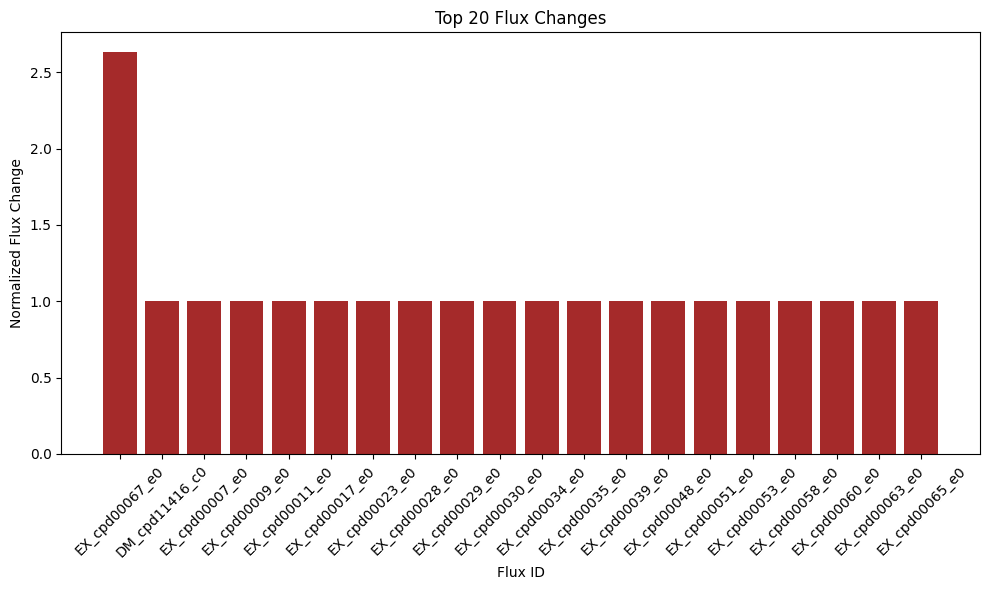

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: fbc41f42-9972-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:22
Completed in 0.064367 seconds
Set Exchange for Fe-enterochlin_e0 as zero. Flux ID: EX_cpd03726_e0
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00132_e0: -994.7738930702296
EX_cpd00023_e0: -741.630028473323
EX_cpd00027_e0: -563.1088069548878
EX_cpd00033_e0: -306.9713450328153
EX_cpd00007_e0: -209.41237626732632
EX_cpd00009_e0: -63.82618673815166
EX_cpd00107_e0: -29.486378559216636
EX_cpd00156_e0: -27.66752721274058
EX_cpd00142_e0: -26.90019921975526
EX_cpd00039_e0: -22.42084063636752
EX_cpd00051_e0: -19.377762422071196
EX_cpd00322_e0: -18.993005406470512
EX_cpd00054_e0: -16.542530314218297
EX_cpd00129_e0: -14.480854950789103
EX_cpd00066_e0: -12.137334946676337
EX_cpd00060_e0: -10.038660316127144
EX_cpd03847_e0: -9.822773864064747
EX_cpd01080_e0: -9.785729516117355
EX_cpd00069_e0: -9.699434444597827
EX_cpd00084_e0: -6.86290548353411
EX_cpd00119_e0: -6.226068070629362
EX_cpd00065_e0: -3.7076585139702

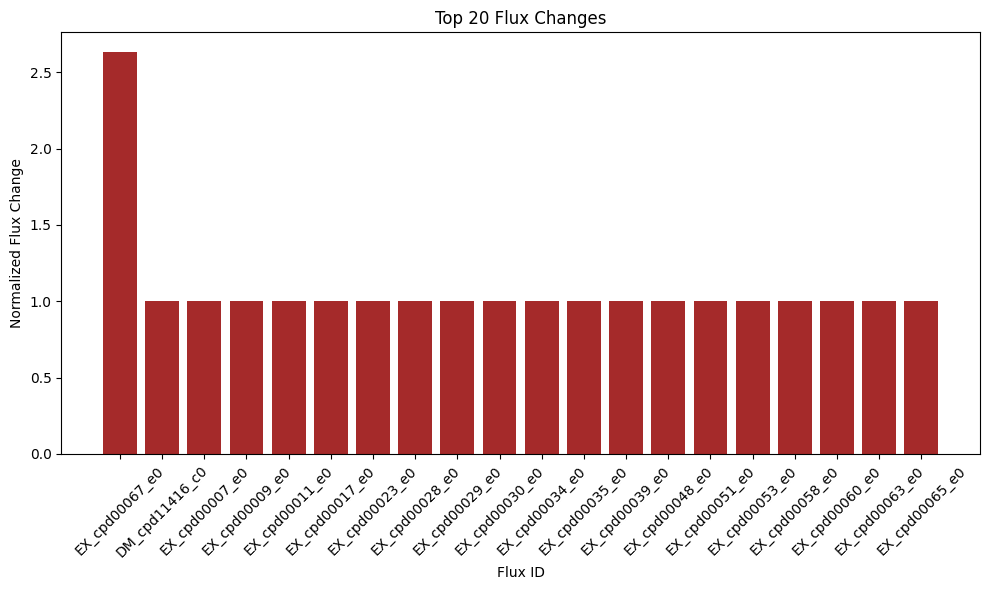

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: fc96a822-9972-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:23
Completed in 0.063583 seconds
Set Exchange for L-Lysine_e0 as zero. Flux ID: EX_cpd00039_e0
Number of Uptake Fluxes: 41

Uptake Fluxes:
EX_cpd00041_e0: -652.1595590377409
EX_cpd00027_e0: -580.1473876062703
EX_cpd00132_e0: -342.64025859074985
EX_cpd00007_e0: -298.69089269857363
EX_cpd00033_e0: -65.3285620022428
EX_cpd00009_e0: -63.509571383878054
EX_cpd00023_e0: -44.47936694499902
EX_cpd00107_e0: -29.340108812102343
EX_cpd00156_e0: -27.53028003602954
EX_cpd00142_e0: -26.76675844033584
EX_cpd00051_e0: -19.281637345082682
EX_cpd00322_e0: -18.898788950144265
EX_cpd00161_e0: -16.497285381894812
EX_cpd00054_e0: -16.460469652857938
EX_cpd00129_e0: -14.409021409502236
EX_cpd00066_e0: -12.077126640331544
EX_cpd00060_e0: -9.988862667939951
EX_cpd03847_e0: -9.77404713941213
EX_cpd01080_e0: -9.737186553176794
EX_cpd00069_e0: -9.651319555870009
EX_cpd00084_e0: -6.828861443587664
EX_cpd00119_e0: -6.195183118095145
E

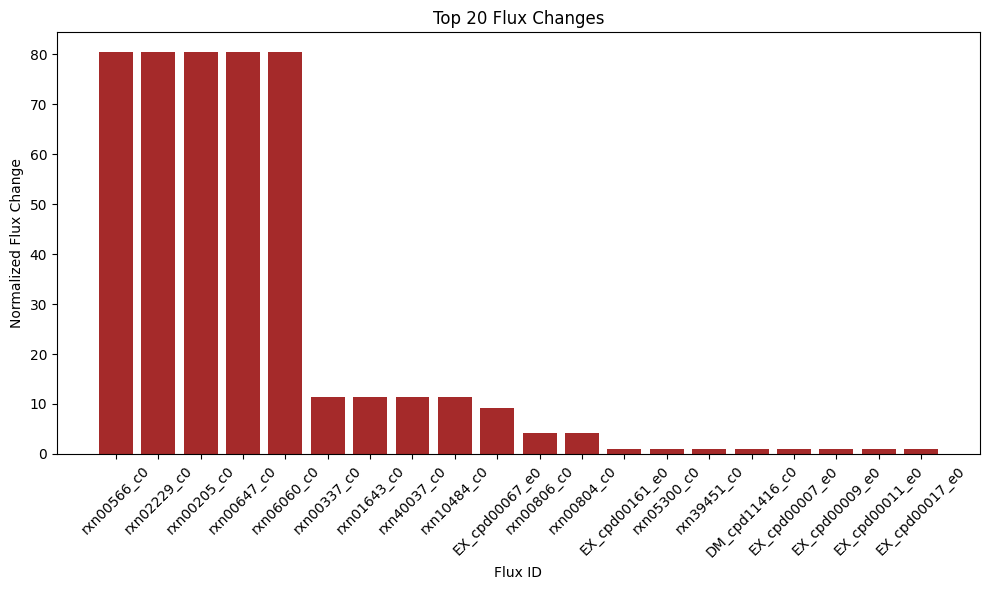

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: fd7a9898-9972-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:25
Completed in 0.062693 seconds
Set Exchange for L-Isoleucine_e0 as zero. Flux ID: EX_cpd00322_e0
Number of Uptake Fluxes: 40

Uptake Fluxes:
EX_cpd00041_e0: -665.2846092194255
EX_cpd00027_e0: -576.9333214061382
EX_cpd00132_e0: -310.68235202374626
EX_cpd00007_e0: -279.52603168750386
EX_cpd00033_e0: -100.4490630109985
EX_cpd00009_e0: -63.335815048942884
EX_cpd00023_e0: -44.35767549579019
EX_cpd00107_e0: -29.259836978069885
EX_cpd00156_e0: -27.45495972675353
EX_cpd00142_e0: -26.693527055787484
EX_cpd00039_e0: -22.248583040264236
EX_cpd00051_e0: -19.228884562100497
EX_cpd00054_e0: -16.41543532471238
EX_cpd00129_e0: -14.369599654710457
EX_cpd00066_e0: -12.04408473474523
EX_cpd00060_e0: -9.961534060148779
EX_cpd03847_e0: -9.747306247112624
EX_cpd01080_e0: -9.71054650804454
EX_cpd00069_e0: -9.624914434929781
EX_cpd00084_e0: -6.810178307955413
EX_cpd00119_e0: -6.178233667967295
EX_cpd00065_e0: -3.67917285845243

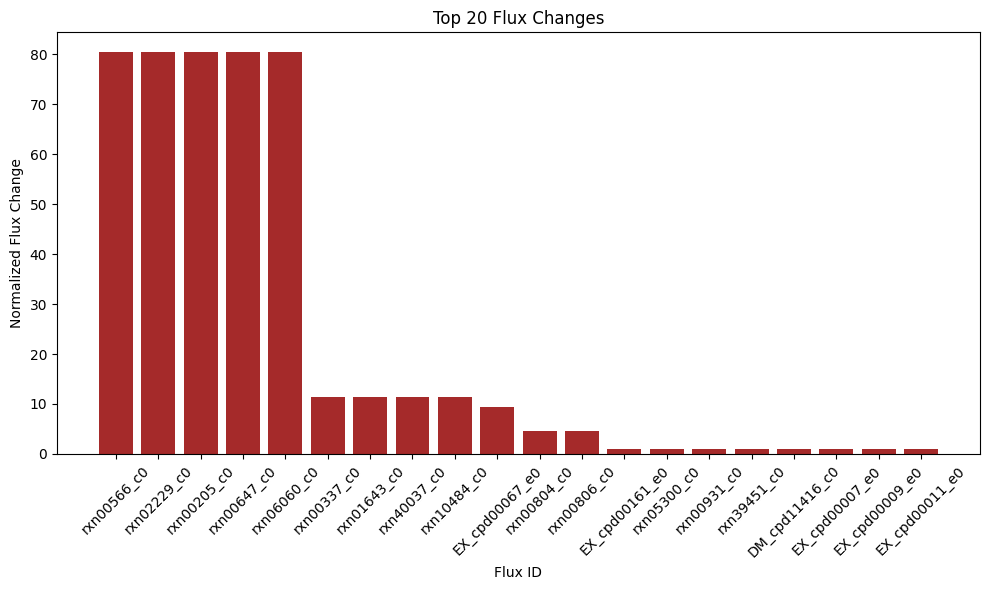

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: fe5f07f8-9972-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:26
Completed in 0.064624 seconds
Set Exchange for Enterobactin_e0 as zero. Flux ID: EX_cpd03453_e0
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00132_e0: -994.7738930702296
EX_cpd00023_e0: -741.630028473323
EX_cpd00027_e0: -563.1088069548878
EX_cpd00033_e0: -306.9713450328153
EX_cpd00007_e0: -209.41237626732632
EX_cpd00009_e0: -63.82618673815166
EX_cpd00107_e0: -29.486378559216636
EX_cpd00156_e0: -27.66752721274058
EX_cpd00142_e0: -26.90019921975526
EX_cpd00039_e0: -22.42084063636752
EX_cpd00051_e0: -19.377762422071196
EX_cpd00322_e0: -18.993005406470512
EX_cpd00054_e0: -16.542530314218297
EX_cpd00129_e0: -14.480854950789103
EX_cpd00066_e0: -12.137334946676337
EX_cpd00060_e0: -10.038660316127144
EX_cpd03847_e0: -9.822773864064747
EX_cpd01080_e0: -9.785729516117355
EX_cpd00069_e0: -9.699434444597827
EX_cpd00084_e0: -6.86290548353411
EX_cpd00119_e0: -6.226068070629362
EX_cpd00065_e0: -3.707658513970292

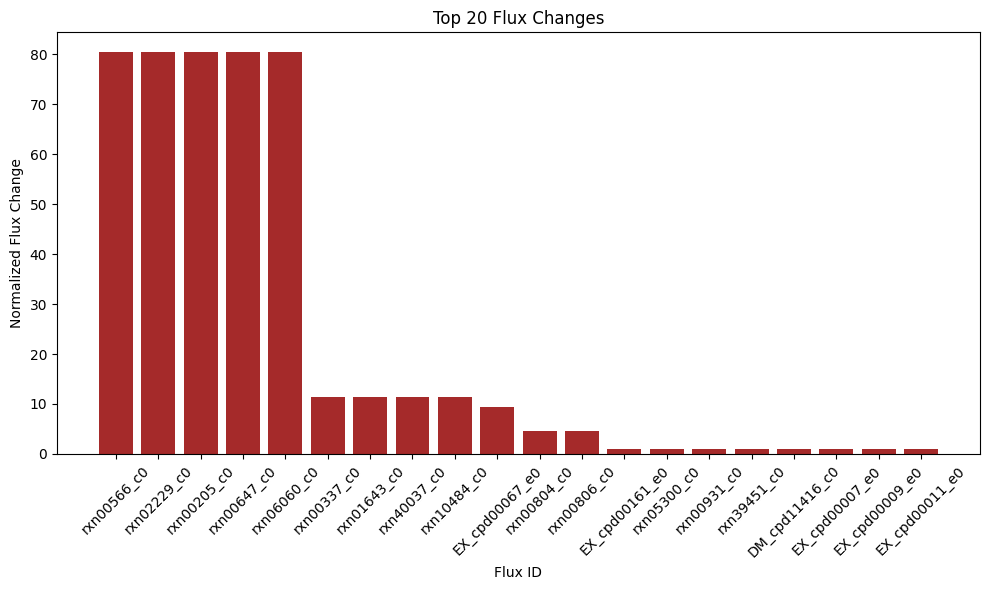

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: ff692502-9972-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:28
Completed in 0.064175 seconds
Set Exchange for PAN_e0 as zero. Flux ID: EX_cpd00644_e0
Number of Uptake Fluxes: 38

Uptake Fluxes:
EX_cpd00132_e0: -994.3359202312508
EX_cpd00023_e0: -741.4452099989957
EX_cpd00027_e0: -563.3787374541532
EX_cpd00033_e0: -306.0576644873757
EX_cpd00007_e0: -209.58796023653295
EX_cpd00009_e0: -63.79387854164548
EX_cpd00107_e0: -29.47145284046462
EX_cpd00156_e0: -28.09414042249195
EX_cpd00142_e0: -26.886582599893945
EX_cpd00039_e0: -22.409491424362727
EX_cpd00051_e0: -19.36795358673476
EX_cpd00322_e0: -18.983391331402487
EX_cpd00054_e0: -16.534156645867643
EX_cpd00129_e0: -14.473524882504917
EX_cpd00066_e0: -12.131191145481854
EX_cpd00060_e0: -10.033578843669458
EX_cpd03847_e0: -9.817801671234578
EX_cpd01080_e0: -9.780776074776718
EX_cpd00069_e0: -9.694524684985163
EX_cpd00084_e0: -6.859431547361726
EX_cpd00119_e0: -6.22291649537686
EX_cpd00065_e0: -3.7057817332019485
EX_cpd

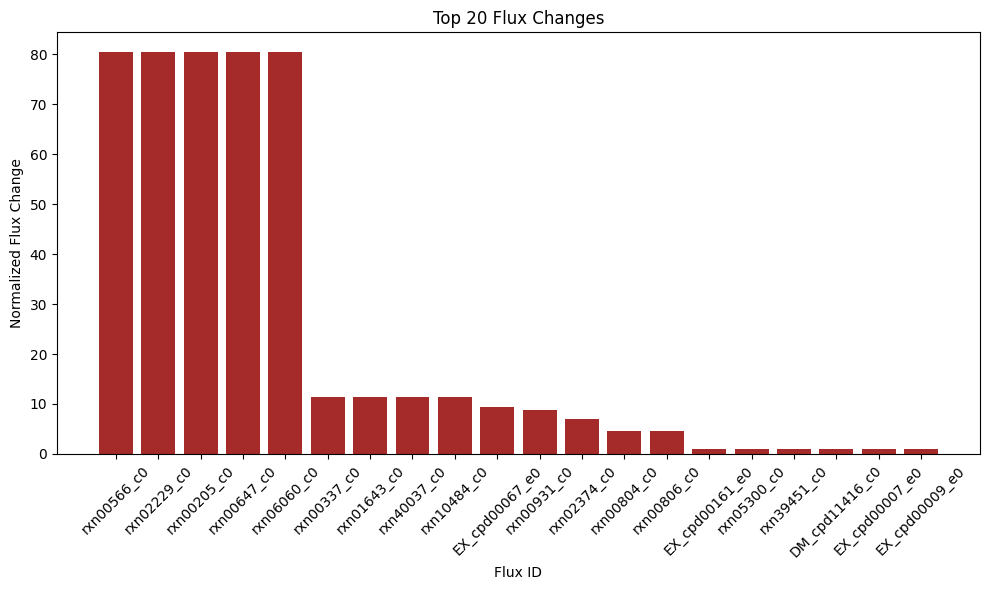

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 003c7c4a-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:29
Completed in 0.047484 seconds
Set Exchange for O2_e0 as zero. Flux ID: EX_cpd00007_e0
Number of Uptake Fluxes: 32

Uptake Fluxes:
EX_cpd00033_e0: -1.4761506276150627
EX_cpd00027_e0: -0.5271966527196651
EX_cpd00054_e0: -0.15815899581589954
EX_cpd00067_e0: -0.10543933054393674
EX_cpd00119_e0: -1.4129967928566383e-16
EX_cpd00053_e0: -1.412996792856634e-16
EX_cpd00011_e0: -1.0520163070959244e-16
EX_cpd00132_e0: -2.6457891612235355e-30
EX_cpd00107_e0: -4.982820140600757e-31
EX_cpd00156_e0: -4.675457569650286e-31
EX_cpd00039_e0: -3.788834768831647e-31
EX_cpd00142_e0: -3.6518304126732207e-31
EX_cpd00051_e0: -3.274593544356845e-31
EX_cpd00322_e0: -3.209574538963479e-31
EX_cpd00066_e0: -2.0510540792271167e-31
EX_cpd00060_e0: -1.6808639776818152e-31
EX_cpd00069_e0: -1.6018318601456685e-31
EX_cpd00084_e0: -1.0197866307631792e-31
EX_cpd01080_e0: -6.762242617151668e-32
EX_cpd00065_e0: -6.265467792451711e-32
EX_cpd1

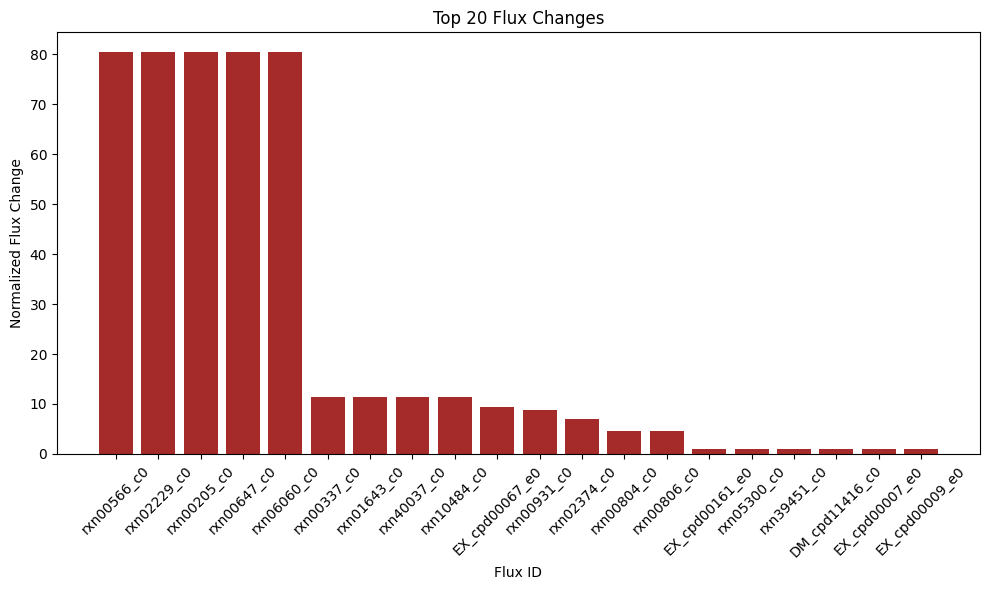

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 010b2bd0-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:31
Completed in 0.064310 seconds
Set Exchange for Na+_e0 as zero. Flux ID: EX_cpd00971_e0
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00132_e0: -994.7738930702296
EX_cpd00023_e0: -741.630028473323
EX_cpd00027_e0: -563.1088069548878
EX_cpd00033_e0: -306.9713450328153
EX_cpd00007_e0: -209.41237626732632
EX_cpd00009_e0: -63.82618673815166
EX_cpd00107_e0: -29.486378559216636
EX_cpd00156_e0: -27.66752721274058
EX_cpd00142_e0: -26.90019921975526
EX_cpd00039_e0: -22.42084063636752
EX_cpd00051_e0: -19.377762422071196
EX_cpd00322_e0: -18.993005406470512
EX_cpd00054_e0: -16.542530314218297
EX_cpd00129_e0: -14.480854950789103
EX_cpd00066_e0: -12.137334946676337
EX_cpd00060_e0: -10.038660316127144
EX_cpd03847_e0: -9.822773864064747
EX_cpd01080_e0: -9.785729516117355
EX_cpd00069_e0: -9.699434444597827
EX_cpd00084_e0: -6.86290548353411
EX_cpd00119_e0: -6.226068070629362
EX_cpd00065_e0: -3.707658513970292
EX_cpd00

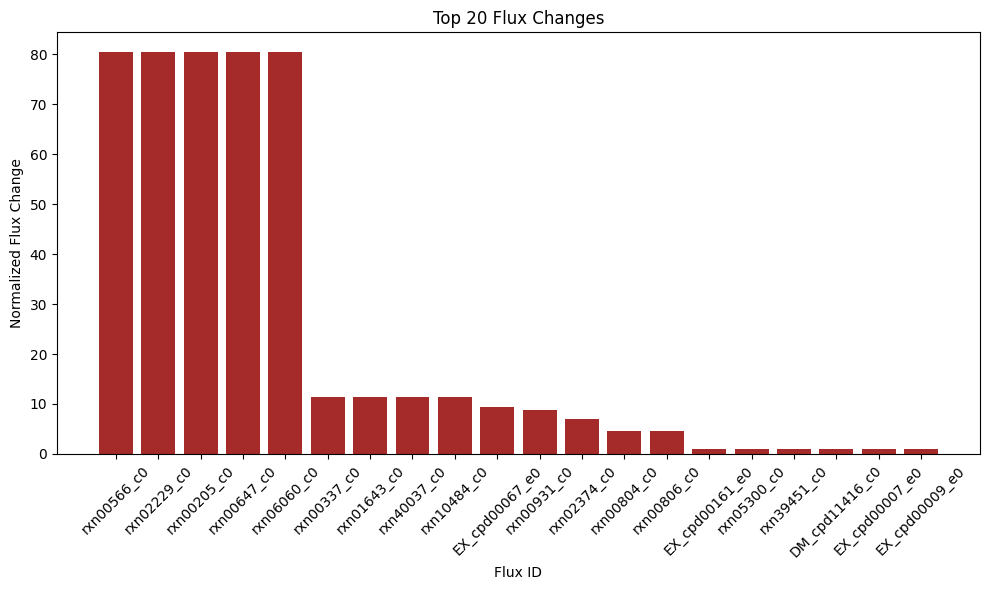

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 01de03de-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:32
Completed in 0.068455 seconds
Set Exchange for L-Asparagine_e0 as zero. Flux ID: EX_cpd00132_e0
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00041_e0: -994.7891245028355
EX_cpd00027_e0: -562.6334280858257
EX_cpd00033_e0: -313.54972977054865
EX_cpd00053_e0: -297.94840573097025
EX_cpd00007_e0: -208.56290856013527
EX_cpd00009_e0: -63.640166001211924
EX_cpd00107_e0: -29.400440825050886
EX_cpd00156_e0: -27.58689050132311
EX_cpd00142_e0: -26.82179887754603
EX_cpd00039_e0: -22.355495336723102
EX_cpd00051_e0: -19.321286141255275
EX_cpd00322_e0: -18.93765049585143
EX_cpd00054_e0: -16.494317286982106
EX_cpd00129_e0: -14.438650654295428
EX_cpd00066_e0: -12.101960814107517
EX_cpd00060_e0: -10.009402748267629
EX_cpd03847_e0: -9.794145494955094
EX_cpd01080_e0: -9.757209112362613
EX_cpd00069_e0: -9.671165546903795
EX_cpd00084_e0: -6.84290361908418
EX_cpd00119_e0: -6.2079222619917545
EX_cpd00065_e0: -3.6968525829

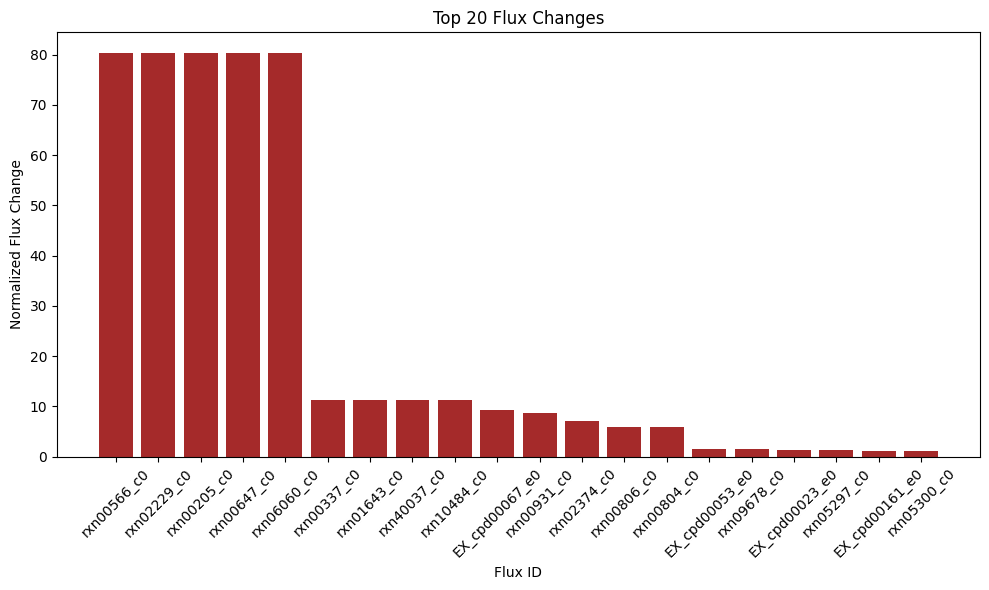

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 02bcc6fa-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:34
Completed in 0.071712 seconds
Set Exchange for L-Alanine_e0 as zero. Flux ID: EX_cpd00035_e0
Number of Uptake Fluxes: 41

Uptake Fluxes:
EX_cpd00067_e0: -1000.0
EX_cpd00041_e0: -929.7006368221182
EX_cpd00033_e0: -920.5673957903978
EX_cpd00023_e0: -668.0576378361551
EX_cpd00007_e0: -240.9944637501706
EX_cpd00027_e0: -185.40485897577628
EX_cpd00009_e0: -58.905780827238196
EX_cpd00107_e0: -27.213252766054175
EX_cpd00156_e0: -25.534617957234648
EX_cpd00142_e0: -24.82644382233221
EX_cpd00039_e0: -20.69240216256309
EX_cpd00051_e0: -17.88391700165364
EX_cpd00322_e0: -17.528821176711062
EX_cpd00054_e0: -15.267254943731414
EX_cpd00132_e0: -14.558928822645834
EX_cpd00129_e0: -13.364515593293666
EX_cpd00066_e0: -11.201659205006855
EX_cpd00060_e0: -9.264772887138262
EX_cpd03847_e0: -9.065529274466662
EX_cpd01080_e0: -9.03134070152199
EX_cpd00069_e0: -8.951698178144309
EX_cpd00084_e0: -6.3338392423431875
EX_cpd0011

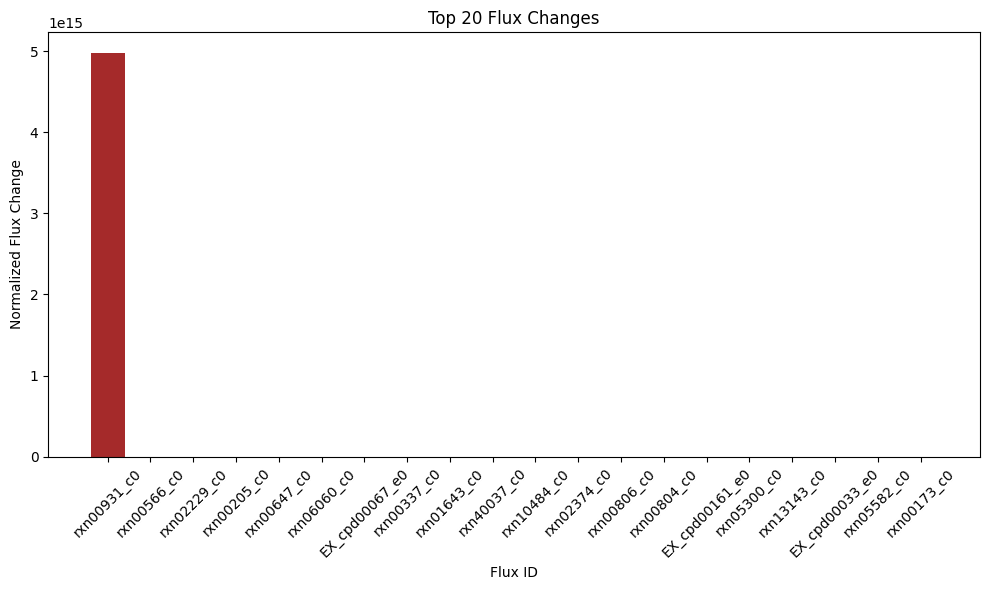

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 03d4ac42-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:35
Completed in 0.038189 seconds
Set Exchange for Folate_e0 as zero. Flux ID: EX_cpd00393_e0
Number of Uptake Fluxes: 4

Uptake Fluxes:
EX_cpd00033_e0: -1.4761506276150624
EX_cpd00027_e0: -0.527196652719665
EX_cpd00054_e0: -0.15815899581589965
EX_cpd00067_e0: -0.10543933054393466
Number of Secretion Fluxes: 4

Secretion Fluxes:
EX_cpd00075_e0: 0.15815899581589962
EX_cpd00001_e0: 0.4744769874476987
EX_cpd00047_e0: 0.6853556485355647
EX_cpd00161_e0: 1.4761506276150627
Objective flux for when eliminate 'EX_cpd00393_e0' (Exchange for Folate_e0): 0.0


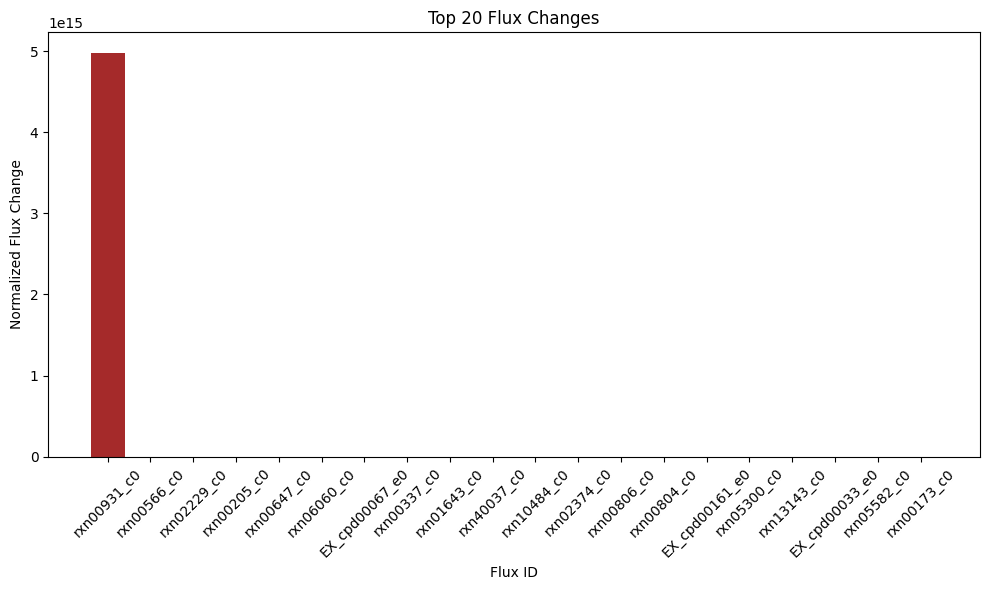

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 04a0f554-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:37
Completed in 0.042369 seconds
Set Exchange for Ca2+_e0 as zero. Flux ID: EX_cpd00063_e0
Number of Uptake Fluxes: 4

Uptake Fluxes:
EX_cpd00033_e0: -1.4761506276150624
EX_cpd00027_e0: -0.527196652719665
EX_cpd00054_e0: -0.15815899581589965
EX_cpd00067_e0: -0.10543933054393466
Number of Secretion Fluxes: 4

Secretion Fluxes:
EX_cpd00075_e0: 0.15815899581589962
EX_cpd00001_e0: 0.4744769874476987
EX_cpd00047_e0: 0.6853556485355647
EX_cpd00161_e0: 1.4761506276150627
Objective flux for when eliminate 'EX_cpd00063_e0' (Exchange for Ca2+_e0): 0.0


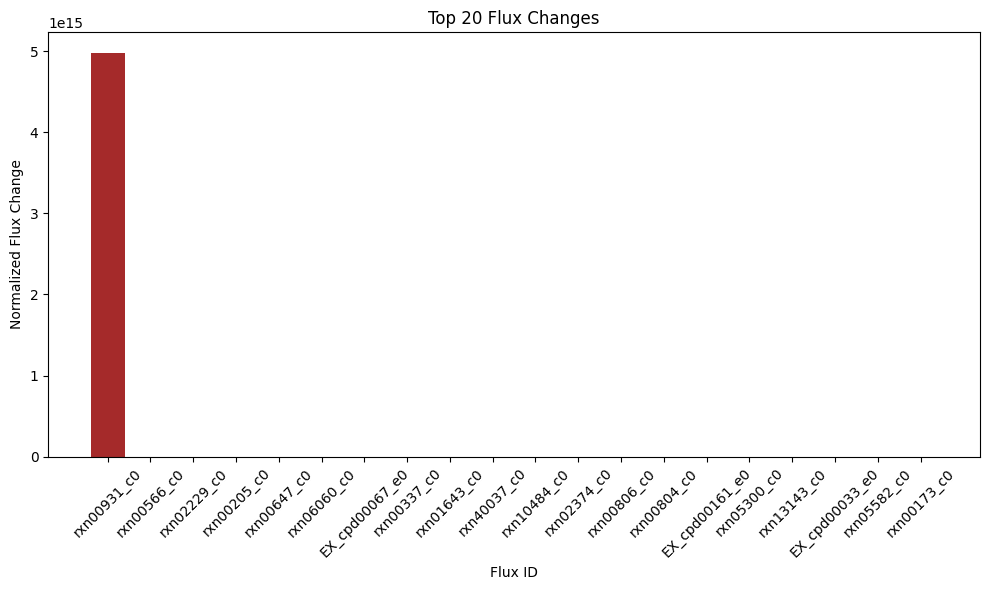

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 056cb112-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:38
Completed in 0.064159 seconds
Set Exchange for Heme_e0 as zero. Flux ID: EX_cpd00028_e0
Number of Uptake Fluxes: 38

Uptake Fluxes:
EX_cpd00132_e0: -993.4632760186989
EX_cpd00023_e0: -742.7038349558211
EX_cpd00027_e0: -563.3402801760552
EX_cpd00033_e0: -298.45810549201286
EX_cpd00007_e0: -210.7796675680181
EX_cpd00009_e0: -63.71013399764554
EX_cpd00107_e0: -29.432764592703986
EX_cpd00156_e0: -27.617220394814712
EX_cpd00142_e0: -26.85128760528706
EX_cpd00039_e0: -22.380073670134298
EX_cpd00051_e0: -19.342528569819706
EX_cpd00322_e0: -18.958471143343147
EX_cpd00054_e0: -16.512451657237083
EX_cpd00129_e0: -14.454524960118226
EX_cpd00066_e0: -12.115266089760691
EX_cpd00060_e0: -10.020407399888555
EX_cpd03847_e0: -9.804913485993849
EX_cpd01080_e0: -9.767936494382749
EX_cpd00069_e0: -9.681798329926776
EX_cpd00084_e0: -6.850426922152426
EX_cpd00119_e0: -6.21474744662076
EX_cpd00065_e0: -3.7009170187741587
EX_

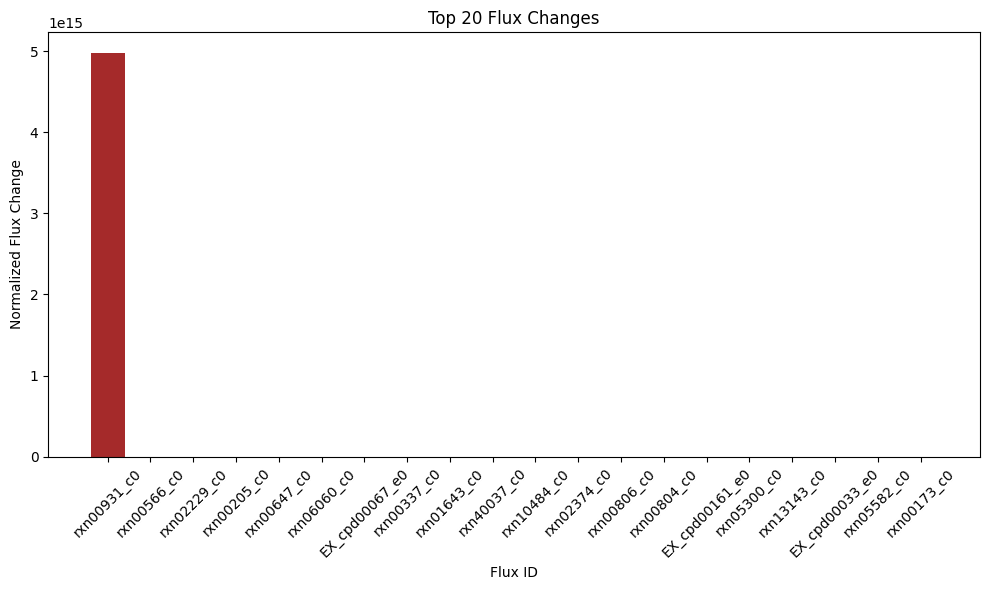

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 063ebcf2-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:40
Completed in 0.063614 seconds
Set Exchange for ocdca_e0 as zero. Flux ID: EX_cpd01080_e0
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00132_e0: -994.7795725711358
EX_cpd00023_e0: -741.5485616210419
EX_cpd00027_e0: -566.8415854755243
EX_cpd00033_e0: -291.3779660984468
EX_cpd00007_e0: -210.29871510132855
EX_cpd00009_e0: -63.75682327307535
EX_cpd00107_e0: -29.454334072565796
EX_cpd00156_e0: -27.637459372953142
EX_cpd00142_e0: -26.870965277951544
EX_cpd00039_e0: -22.39647466253219
EX_cpd00051_e0: -19.356703530488087
EX_cpd00322_e0: -18.97236465172389
EX_cpd00054_e0: -16.524552626969918
EX_cpd00129_e0: -14.465117800752434
EX_cpd00066_e0: -12.12414463010713
EX_cpd00060_e0: -10.02775074593878
EX_cpd03847_e0: -9.8120989096844
EX_cpd00214_e0: -9.775094819889123
EX_cpd00069_e0: -9.688893530020733
EX_cpd00084_e0: -6.855447182654181
EX_cpd00119_e0: -6.219301856366196
EX_cpd00065_e0: -3.703629195364137
EX_cpd0

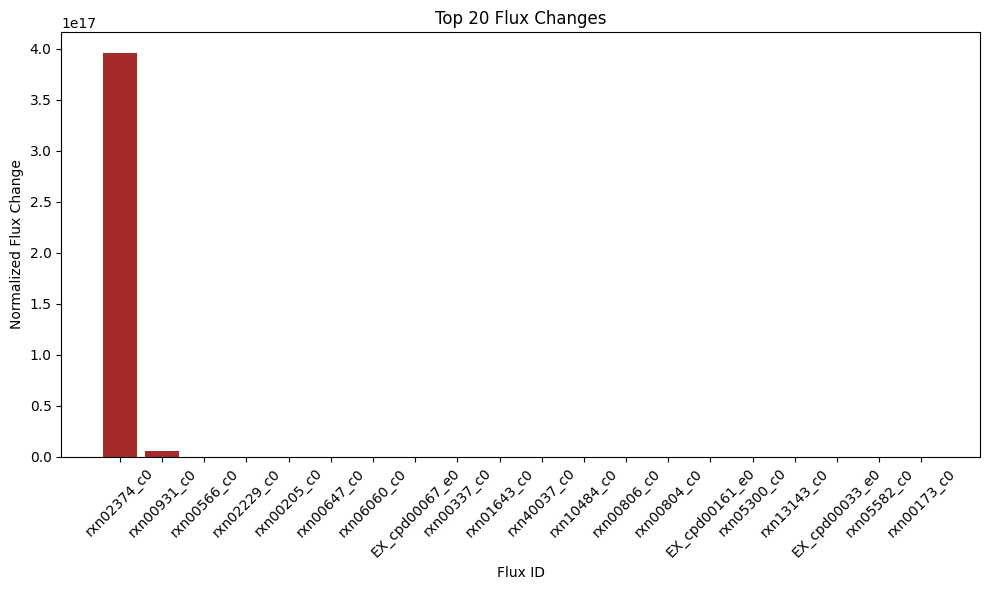

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 07140312-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:41
Completed in 0.043720 seconds
Set Exchange for Sulfate_e0 as zero. Flux ID: EX_cpd00048_e0
Number of Uptake Fluxes: 4

Uptake Fluxes:
EX_cpd00033_e0: -1.4761506276150627
EX_cpd00027_e0: -0.5271966527196654
EX_cpd00054_e0: -0.15815899581589948
EX_cpd00067_e0: -0.10543933054393173
Number of Secretion Fluxes: 6

Secretion Fluxes:
EX_cpd03847_e0: 1.4439219430427661e-16
EX_cpd00011_e0: 1.4439219430427666e-16
EX_cpd00075_e0: 0.15815899581589946
EX_cpd00001_e0: 0.4744769874476995
EX_cpd00047_e0: 0.6853556485355651
EX_cpd00161_e0: 1.4761506276150627
Objective flux for when eliminate 'EX_cpd00048_e0' (Exchange for Sulfate_e0): 0.0


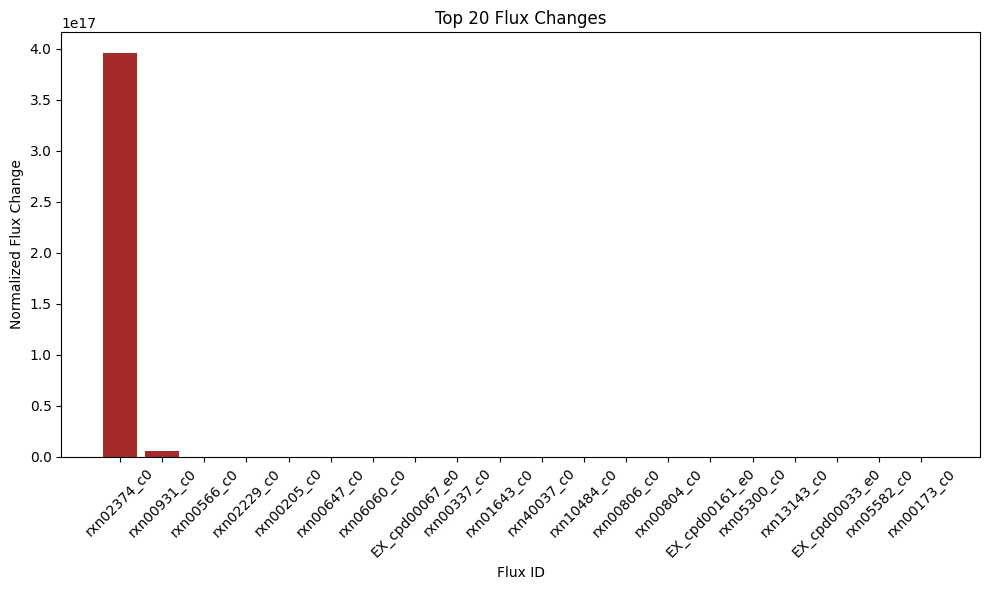

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 081c508e-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:43
Completed in 0.043412 seconds
Set Exchange for Niacin_e0 as zero. Flux ID: EX_cpd00218_e0
Number of Uptake Fluxes: 4

Uptake Fluxes:
EX_cpd00033_e0: -1.4761506276150627
EX_cpd00027_e0: -0.5271966527196654
EX_cpd00054_e0: -0.15815899581589948
EX_cpd00067_e0: -0.10543933054393173
Number of Secretion Fluxes: 6

Secretion Fluxes:
EX_cpd03847_e0: 1.4439219430427661e-16
EX_cpd00011_e0: 1.4439219430427666e-16
EX_cpd00075_e0: 0.15815899581589946
EX_cpd00001_e0: 0.4744769874476995
EX_cpd00047_e0: 0.6853556485355651
EX_cpd00161_e0: 1.4761506276150627
Objective flux for when eliminate 'EX_cpd00218_e0' (Exchange for Niacin_e0): 0.0


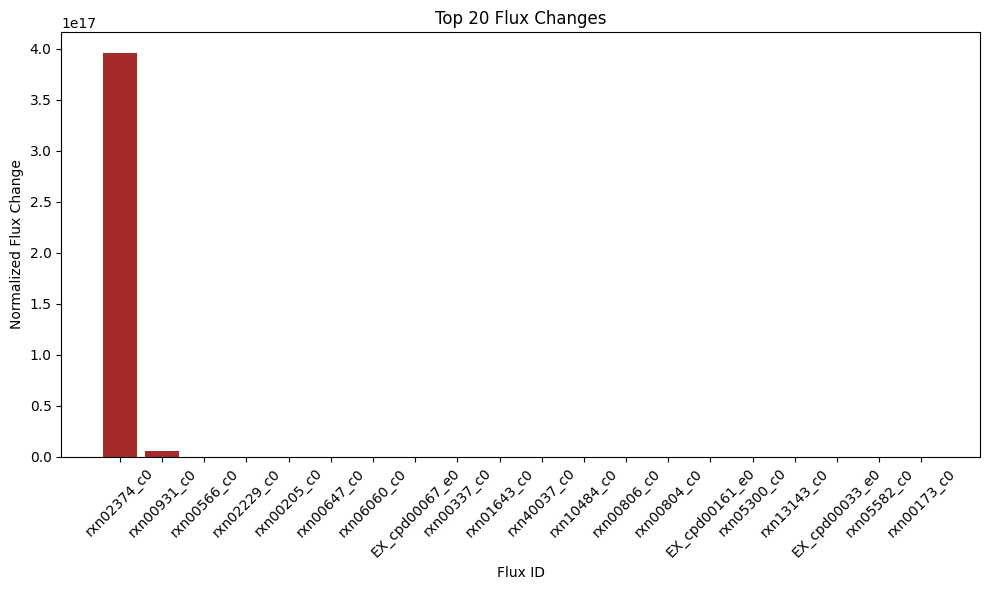

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 08eafdf8-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:44
Completed in 0.064387 seconds
Set Exchange for S-Adenosyl-L-methionine_e0 as zero. Flux ID: EX_cpd00017_e0
Number of Uptake Fluxes: 38

Uptake Fluxes:
EX_cpd00132_e0: -994.9989299539111
EX_cpd00023_e0: -741.5608981113742
EX_cpd00027_e0: -563.0464768341166
EX_cpd00033_e0: -305.88510284991264
EX_cpd00007_e0: -209.56031091906476
EX_cpd00009_e0: -63.767326952708466
EX_cpd00107_e0: -29.45918655537334
EX_cpd00156_e0: -27.64201253297777
EX_cpd00142_e0: -26.875392161163774
EX_cpd00039_e0: -22.40016439145227
EX_cpd00051_e0: -19.359892469367534
EX_cpd00322_e0: -18.97549027232234
EX_cpd00054_e0: -16.52727498040446
EX_cpd00129_e0: -14.46750087060997
EX_cpd00066_e0: -12.12614203406231
EX_cpd00060_e0: -10.249620204603154
EX_cpd03847_e0: -9.813715413427031
EX_cpd01080_e0: -9.776705227357127
EX_cpd00069_e0: -9.69048973617371
EX_cpd00084_e0: -6.856576589943136
EX_cpd00119_e0: -6.220326461276922
EX_cpd00065_e0: -3.70423

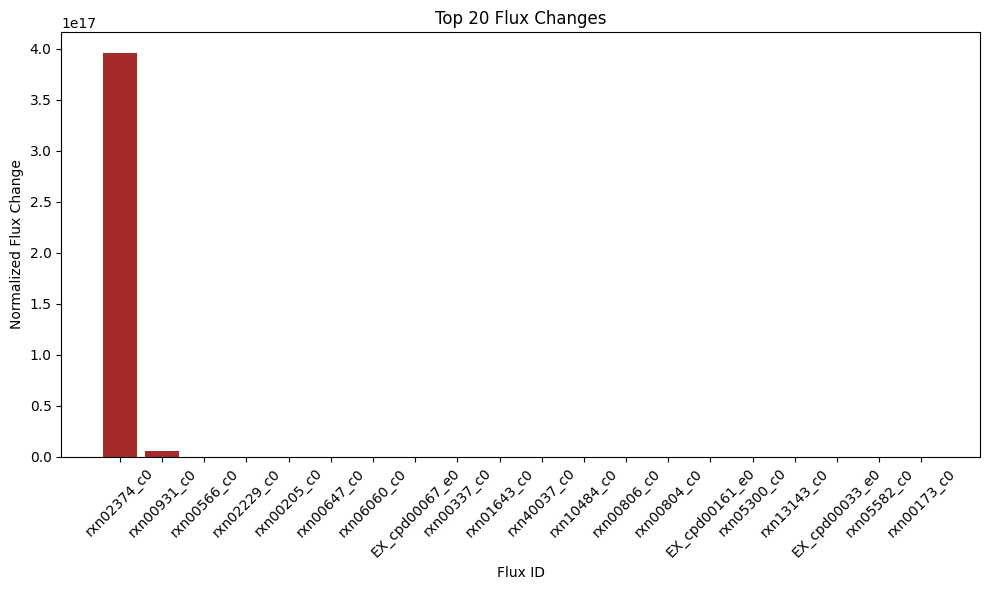

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 09bf0c2e-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:45
Completed in 0.062792 seconds
Set Exchange for L-Leucine_e0 as zero. Flux ID: EX_cpd00107_e0
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00041_e0: -950.1121281283425
EX_cpd00027_e0: -584.4804582548712
EX_cpd00053_e0: -302.10291241509685
EX_cpd00033_e0: -281.4841056357963
EX_cpd00007_e0: -214.61673983935836
EX_cpd00009_e0: -63.068109281903396
EX_cpd00156_e0: -56.47507644319021
EX_cpd00142_e0: -26.58069972215477
EX_cpd00039_e0: -22.15454345170433
EX_cpd00051_e0: -19.14760853704248
EX_cpd00322_e0: -18.767421363924317
EX_cpd00054_e0: -16.346051095560618
EX_cpd00132_e0: -15.587674097845055
EX_cpd00129_e0: -14.308862697356641
EX_cpd00066_e0: -11.993177188364125
EX_cpd00060_e0: -9.919428971355954
EX_cpd03847_e0: -9.7061066494849
EX_cpd01080_e0: -9.669502285288612
EX_cpd00069_e0: -9.584232159040702
EX_cpd00084_e0: -6.781393267354736
EX_cpd00119_e0: -6.15211971045768
EX_cpd00065_e0: -3.6636218500478304
EX

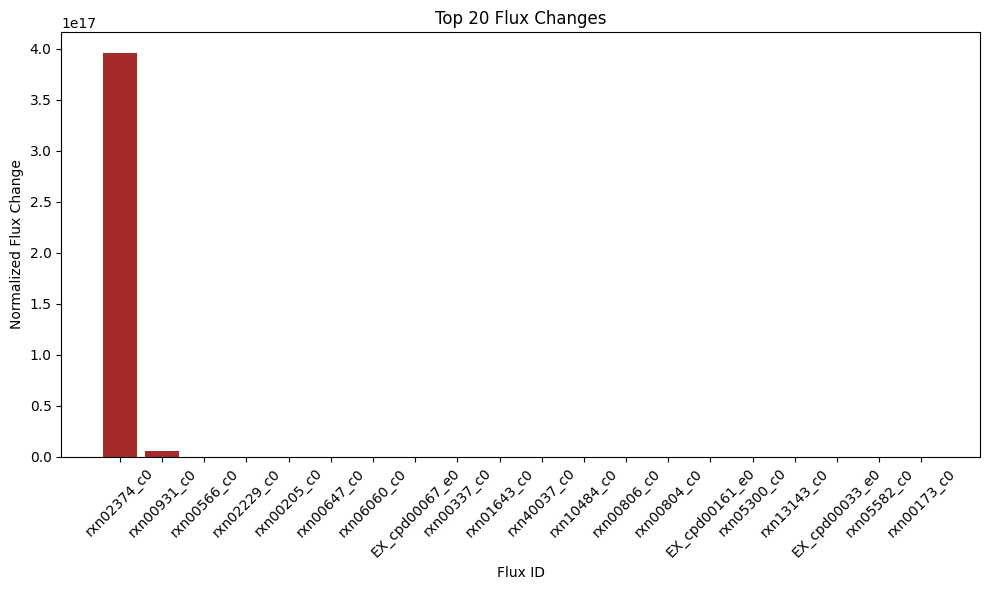

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 0a9329b4-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:47
Completed in 0.067019 seconds
Set Exchange for H+_e0 as zero. Flux ID: EX_cpd00067_e0
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00132_e0: -994.7811571653099
EX_cpd00023_e0: -760.2793862188033
EX_cpd00027_e0: -555.3806701374968
EX_cpd00033_e0: -323.0919035513269
EX_cpd00007_e0: -208.14170392911217
EX_cpd00009_e0: -63.73747070250366
EX_cpd00107_e0: -29.44539358510725
EX_cpd00156_e0: -27.62907037463794
EX_cpd00142_e0: -26.862808939143306
EX_cpd00039_e0: -22.389676498284345
EX_cpd00051_e0: -19.350828049999315
EX_cpd00322_e0: -18.96660583240006
EX_cpd00054_e0: -16.519536809767747
EX_cpd00129_e0: -14.460727098735935
EX_cpd00066_e0: -12.12046450063131
EX_cpd00060_e0: -10.024706950089902
EX_cpd03847_e0: -9.809120572200076
EX_cpd01080_e0: -9.772127714524322
EX_cpd00069_e0: -9.685952589958092
EX_cpd00084_e0: -6.853366299093735
EX_cpd00119_e0: -6.217414066606265
EX_cpd00065_e0: -3.702505005956538
EX_cpd00

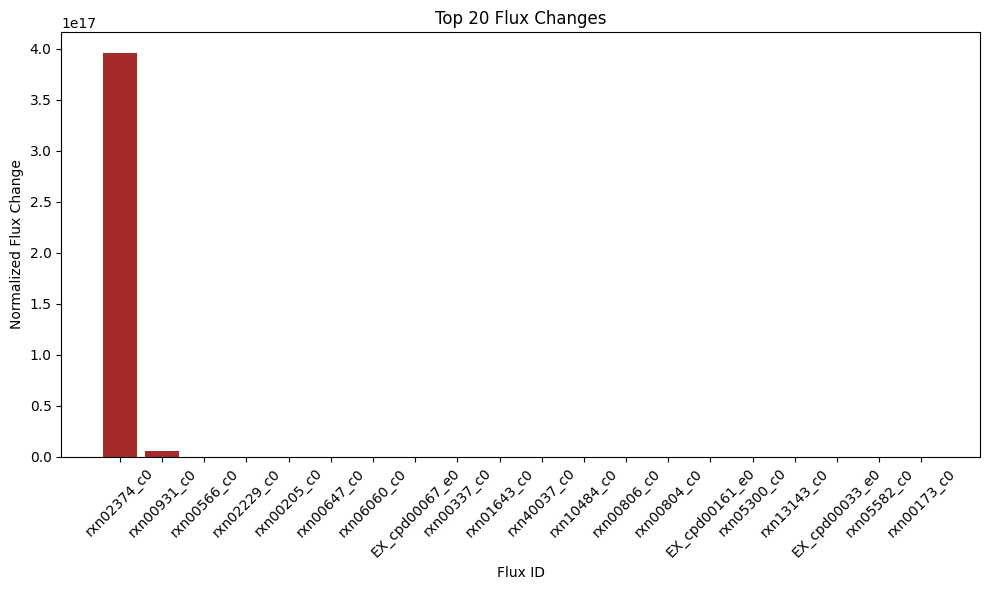

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 0b9fe784-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:49
Completed in 0.064376 seconds
Set Exchange for L-Arginine_e0 as zero. Flux ID: EX_cpd00051_e0
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00132_e0: -999.7994275183709
EX_cpd00023_e0: -706.2018374546851
EX_cpd00027_e0: -560.0392538034062
EX_cpd00033_e0: -328.0186747563813
EX_cpd00007_e0: -205.89334839688487
EX_cpd00009_e0: -63.40627443226031
EX_cpd00107_e0: -29.292387756300965
EX_cpd00156_e0: -27.48550262779835
EX_cpd00142_e0: -26.723222883554726
EX_cpd00039_e0: -22.273333987887156
EX_cpd00322_e0: -18.86805047647857
EX_cpd00067_e0: -17.397408567769745
EX_cpd00054_e0: -16.433697053074773
EX_cpd00129_e0: -14.38558544615518
EX_cpd00066_e0: -12.057483453661225
EX_cpd00060_e0: -9.972615997696838
EX_cpd03847_e0: -9.758149862004876
EX_cpd01080_e0: -9.72134922872008
EX_cpd00069_e0: -9.635621892237191
EX_cpd00084_e0: -6.817754447356072
EX_cpd00119_e0: -6.1851067860279505
EX_cpd00065_e0: -3.683265838870575


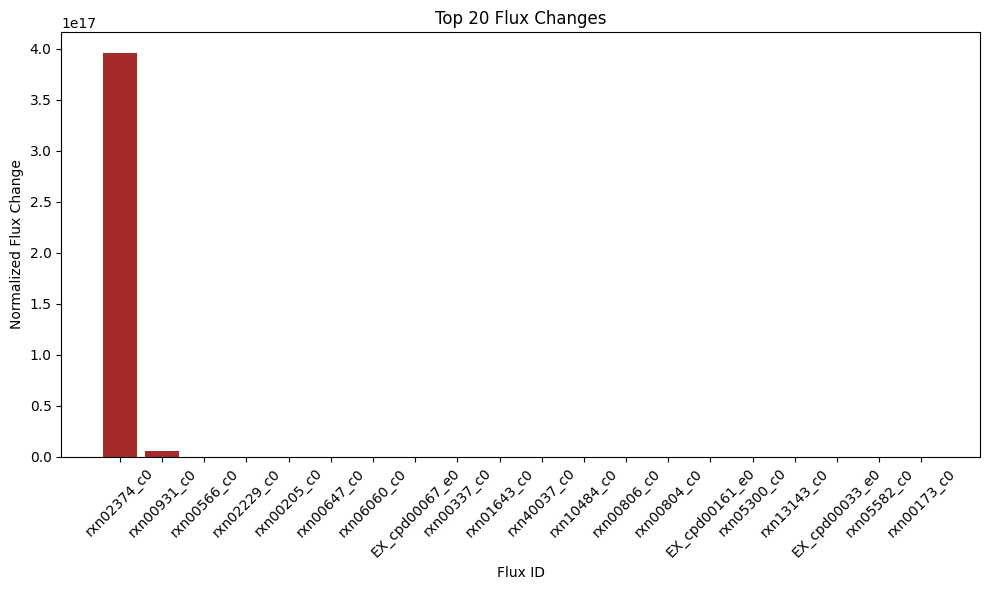

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 0c730bfa-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:50
Completed in 0.064296 seconds
Set Exchange for Methanol_e0 as zero. Flux ID: EX_cpd00116_e0
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00132_e0: -994.7738930702296
EX_cpd00023_e0: -741.630028473323
EX_cpd00027_e0: -563.1088069548878
EX_cpd00033_e0: -306.9713450328153
EX_cpd00007_e0: -209.41237626732632
EX_cpd00009_e0: -63.82618673815166
EX_cpd00107_e0: -29.486378559216636
EX_cpd00156_e0: -27.66752721274058
EX_cpd00142_e0: -26.90019921975526
EX_cpd00039_e0: -22.42084063636752
EX_cpd00051_e0: -19.377762422071196
EX_cpd00322_e0: -18.993005406470512
EX_cpd00054_e0: -16.542530314218297
EX_cpd00129_e0: -14.480854950789103
EX_cpd00066_e0: -12.137334946676337
EX_cpd00060_e0: -10.038660316127144
EX_cpd03847_e0: -9.822773864064747
EX_cpd01080_e0: -9.785729516117355
EX_cpd00069_e0: -9.699434444597827
EX_cpd00084_e0: -6.86290548353411
EX_cpd00119_e0: -6.226068070629362
EX_cpd00065_e0: -3.707658513970292
EX_

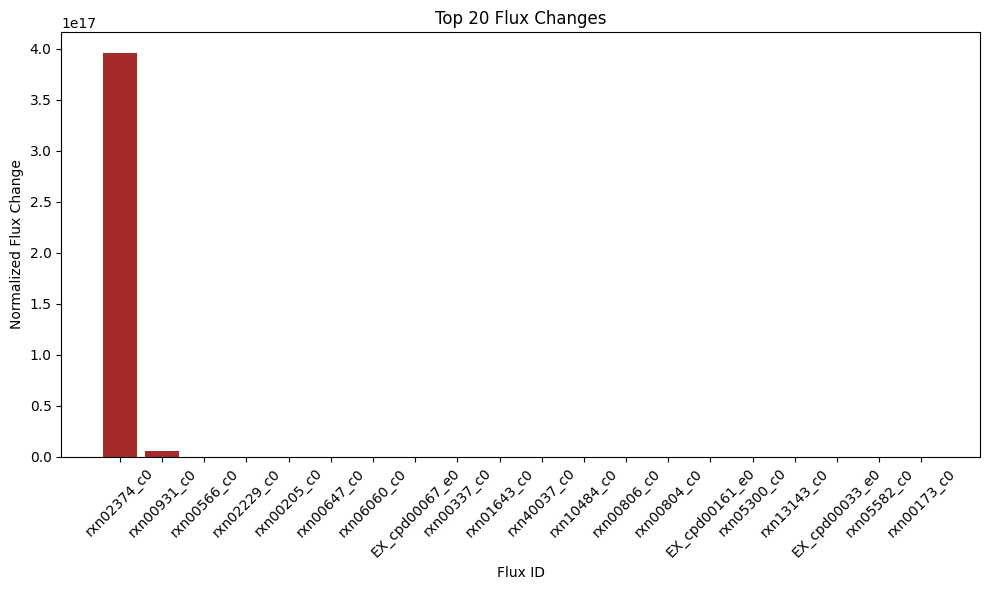

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 0d51d736-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:51
Completed in 0.066188 seconds
Set Exchange for Glycerol_e0 as zero. Flux ID: EX_cpd00100_e0
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00132_e0: -994.7800453057108
EX_cpd00023_e0: -742.35629817852
EX_cpd00027_e0: -561.4506618738519
EX_cpd00033_e0: -304.4907412776582
EX_cpd00007_e0: -209.68328263021675
EX_cpd00009_e0: -63.751049788946474
EX_cpd00107_e0: -29.45166684227381
EX_cpd00156_e0: -27.634956669322108
EX_cpd00142_e0: -26.86853198401294
EX_cpd00039_e0: -22.394446555038517
EX_cpd00051_e0: -19.354950688754087
EX_cpd00322_e0: -18.97064661370664
EX_cpd00054_e0: -16.523056249994642
EX_cpd00129_e0: -14.463807915422704
EX_cpd00066_e0: -12.123046731042693
EX_cpd00060_e0: -10.02684268532929
EX_cpd03847_e0: -9.81121037737621
EX_cpd01080_e0: -9.774209638477574
EX_cpd00069_e0: -9.688016154546704
EX_cpd00084_e0: -6.854826389247496
EX_cpd00119_e0: -6.2187386689498565
EX_cpd00065_e0: -3.7032938140937333
EX

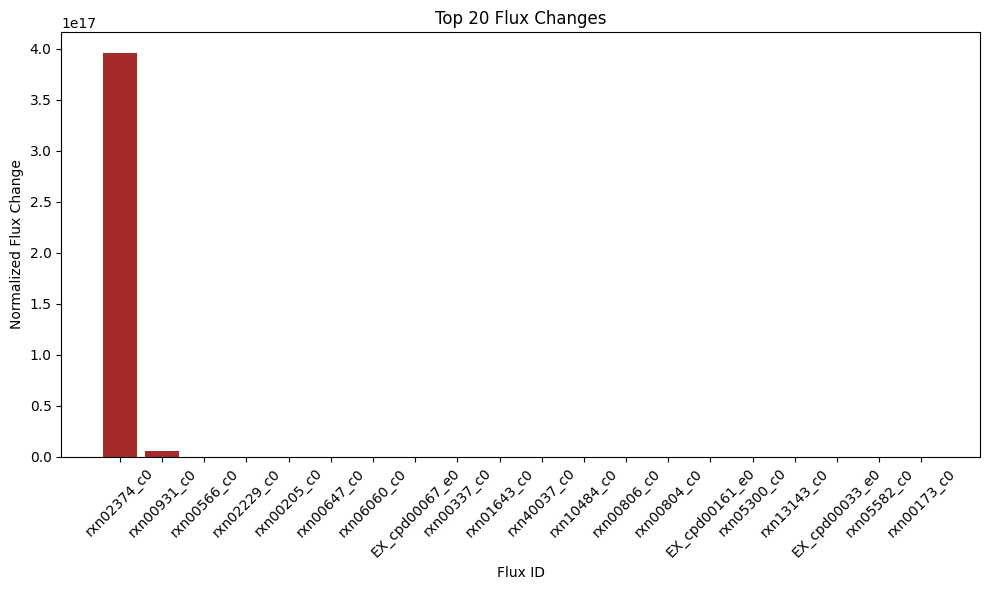

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 0e26d526-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:53
Completed in 0.065027 seconds
Set Exchange for Myristic acid_e0 as zero. Flux ID: EX_cpd03847_e0
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00027_e0: -589.5088174664631
EX_cpd00041_e0: -573.2463557392431
EX_cpd00132_e0: -421.5577994924828
EX_cpd00033_e0: -216.37270674930124
EX_cpd00007_e0: -214.6358825583683
EX_cpd00023_e0: -167.94959180344634
EX_cpd00009_e0: -63.45659644920439
EX_cpd00107_e0: -29.315635487631877
EX_cpd00156_e0: -27.507316335369826
EX_cpd00142_e0: -26.744431612288807
EX_cpd00039_e0: -22.291011088460245
EX_cpd00051_e0: -19.265554045252742
EX_cpd00322_e0: -18.88302499381271
EX_cpd00054_e0: -16.446739560126158
EX_cpd00129_e0: -14.397002481470066
EX_cpd00066_e0: -12.067052804517484
EX_cpd00060_e0: -9.980530705753665
EX_cpd01080_e0: -9.7290645203831
EX_cpd00069_e0: -9.643269146903531
EX_cpd00084_e0: -6.823165318091291
EX_cpd00119_e0: -6.190015559666031
EX_cpd00065_e0: -3.686189041149

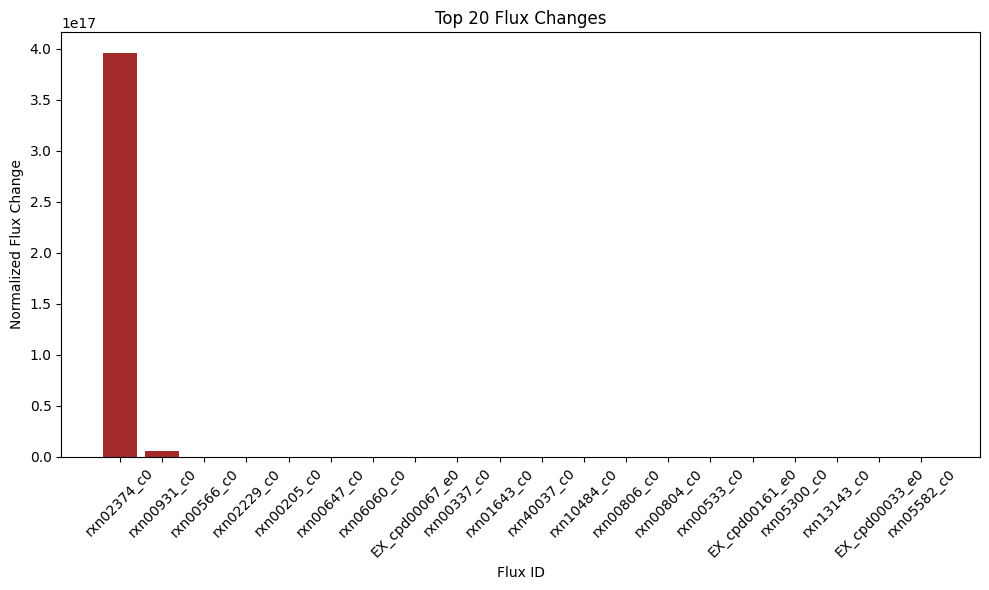

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 0efcd13a-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:54
Completed in 0.065801 seconds
Set Exchange for L-Tyrosine_e0 as zero. Flux ID: EX_cpd00069_e0
Number of Uptake Fluxes: 38

Uptake Fluxes:
EX_cpd00132_e0: -985.445891231564
EX_cpd00023_e0: -727.153769515287
EX_cpd00027_e0: -576.0742323920856
EX_cpd00033_e0: -227.33364396415232
EX_cpd00007_e0: -217.097977988324
EX_cpd00009_e0: -62.23782714213008
EX_cpd00107_e0: -28.752589267877724
EX_cpd00156_e0: -26.97900131778319
EX_cpd00142_e0: -26.23076882216681
EX_cpd00039_e0: -21.862882230972215
EX_cpd00051_e0: -18.8955331606219
EX_cpd00322_e0: -18.52035109425577
EX_cpd00054_e0: -16.13085780001501
EX_cpd00129_e0: -14.120488679592711
EX_cpd00066_e0: -11.835288820822717
EX_cpd00060_e0: -9.788841186098356
EX_cpd03847_e0: -9.57832722039777
EX_cpd01080_e0: -9.542204747131386
EX_cpd00084_e0: -6.692117248513124
EX_cpd00119_e0: -6.071127983015689
EX_cpd00065_e0: -3.6153908213464194
EX_cpd00220_e0: -0.6448061171614662
EX_cp

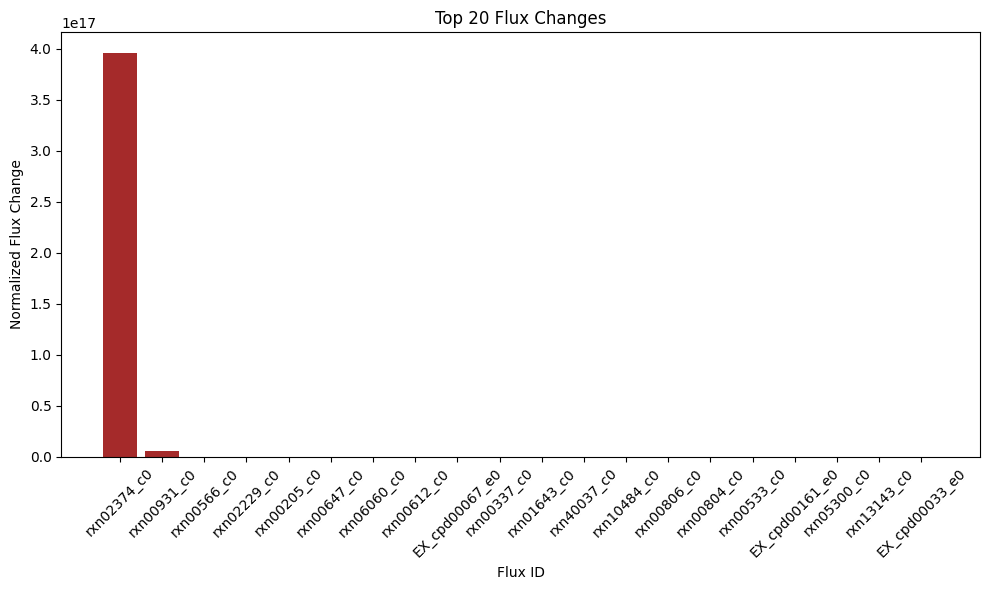

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 1009ffda-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:56
Completed in 0.037299 seconds
Set Exchange for fe3_e0 as zero. Flux ID: EX_cpd10516_e0
Number of Uptake Fluxes: 4

Uptake Fluxes:
EX_cpd00033_e0: -1.4761506276150624
EX_cpd00027_e0: -0.527196652719665
EX_cpd00054_e0: -0.15815899581589965
EX_cpd00067_e0: -0.10543933054393466
Number of Secretion Fluxes: 4

Secretion Fluxes:
EX_cpd00075_e0: 0.15815899581589962
EX_cpd00001_e0: 0.4744769874476987
EX_cpd00047_e0: 0.6853556485355647
EX_cpd00161_e0: 1.4761506276150627
Objective flux for when eliminate 'EX_cpd10516_e0' (Exchange for fe3_e0): 0.0


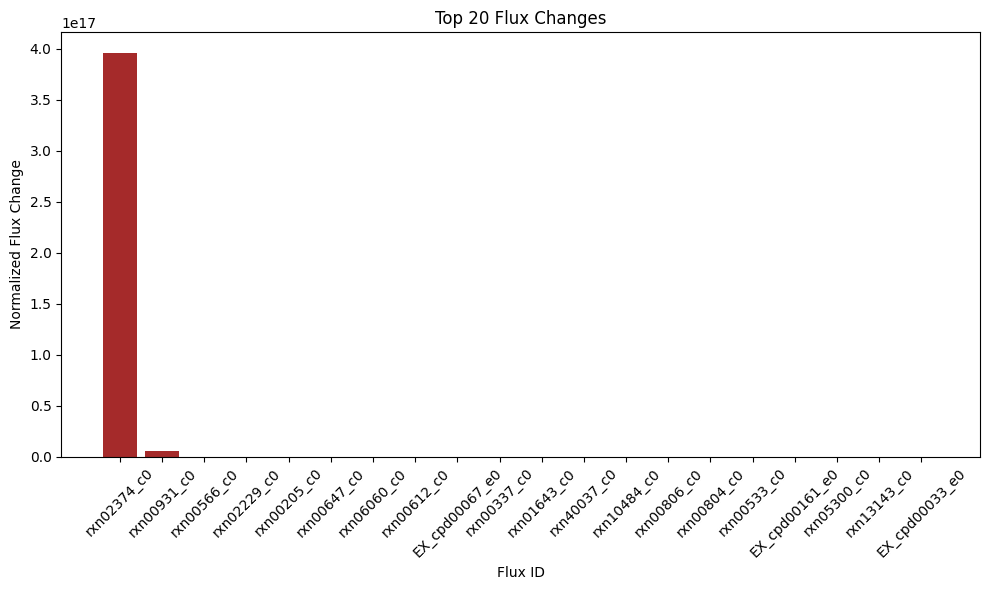

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 10d9f816-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:57
Completed in 0.067768 seconds
Set Exchange for L-Serine_e0 as zero. Flux ID: EX_cpd00054_e0
Number of Uptake Fluxes: 41

Uptake Fluxes:
EX_cpd00041_e0: -680.3612014103968
EX_cpd00027_e0: -569.4142439654865
EX_cpd00033_e0: -318.73588417696226
EX_cpd00132_e0: -314.4222855146543
EX_cpd00007_e0: -208.3692537062188
EX_cpd00009_e0: -63.709017461324926
EX_cpd00023_e0: -44.61905038280648
EX_cpd00107_e0: -29.43224877600017
EX_cpd00156_e0: -27.61673639598582
EX_cpd00142_e0: -26.850817029625585
EX_cpd00039_e0: -22.379681453637083
EX_cpd00051_e0: -19.34218958707485
EX_cpd00322_e0: -18.95813889130262
EX_cpd00129_e0: -14.454271640882622
EX_cpd00066_e0: -12.115053766633496
EX_cpd00060_e0: -10.020231789694035
EX_cpd03847_e0: -9.804741652385086
EX_cpd01080_e0: -9.767765308805131
EX_cpd00069_e0: -9.681628653942521
EX_cpd00084_e0: -6.850306866674018
EX_cpd00119_e0: -6.214638531587212
EX_cpd00065_e0: -3.7008521592597994
E

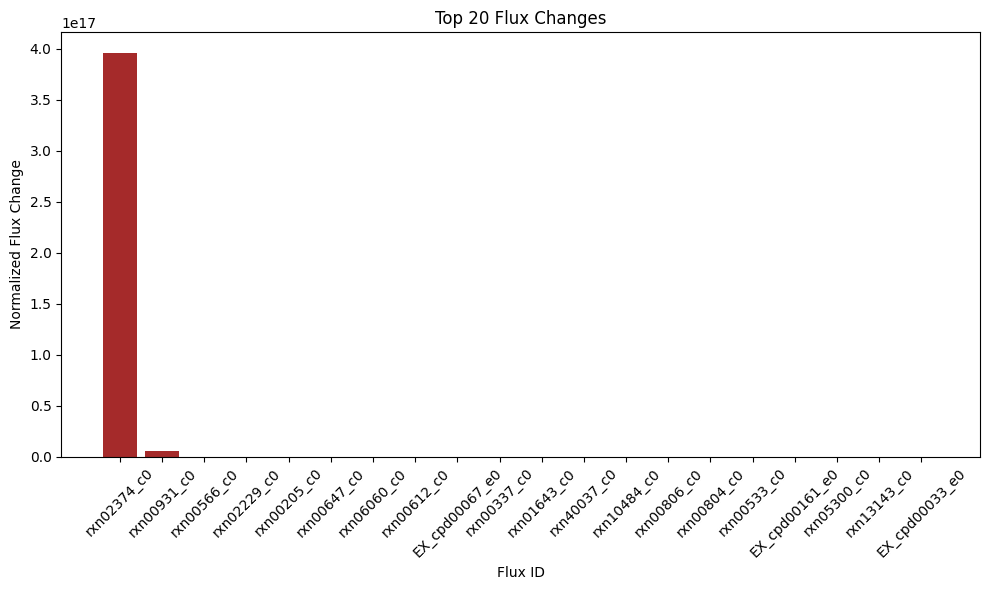

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 11b14c26-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:49:59
Completed in 0.064208 seconds
Set Exchange for L-Histidine_e0 as zero. Flux ID: EX_cpd00119_e0
Number of Uptake Fluxes: 38

Uptake Fluxes:
EX_cpd00132_e0: -994.8405575224092
EX_cpd00023_e0: -728.380496360117
EX_cpd00027_e0: -565.9455022222533
EX_cpd00033_e0: -292.2640555769379
EX_cpd00007_e0: -211.4628456960146
EX_cpd00009_e0: -63.01201706431186
EX_cpd00107_e0: -29.11024900424491
EX_cpd00156_e0: -27.314599006355472
EX_cpd00142_e0: -26.557059083340796
EX_cpd00039_e0: -22.134839397059235
EX_cpd00051_e0: -19.13057882366747
EX_cpd00322_e0: -18.750729785652418
EX_cpd00054_e0: -16.331513062550794
EX_cpd00129_e0: -14.296136521657717
EX_cpd00066_e0: -11.982510562838621
EX_cpd00060_e0: -9.910606719120157
EX_cpd03847_e0: -9.697474124232036
EX_cpd01080_e0: -9.660902315632919
EX_cpd00069_e0: -9.575708027879765
EX_cpd00084_e0: -6.775361956269435
EX_cpd00065_e0: -3.660363457236005
EX_cpd00220_e0: -0.6528270012537888

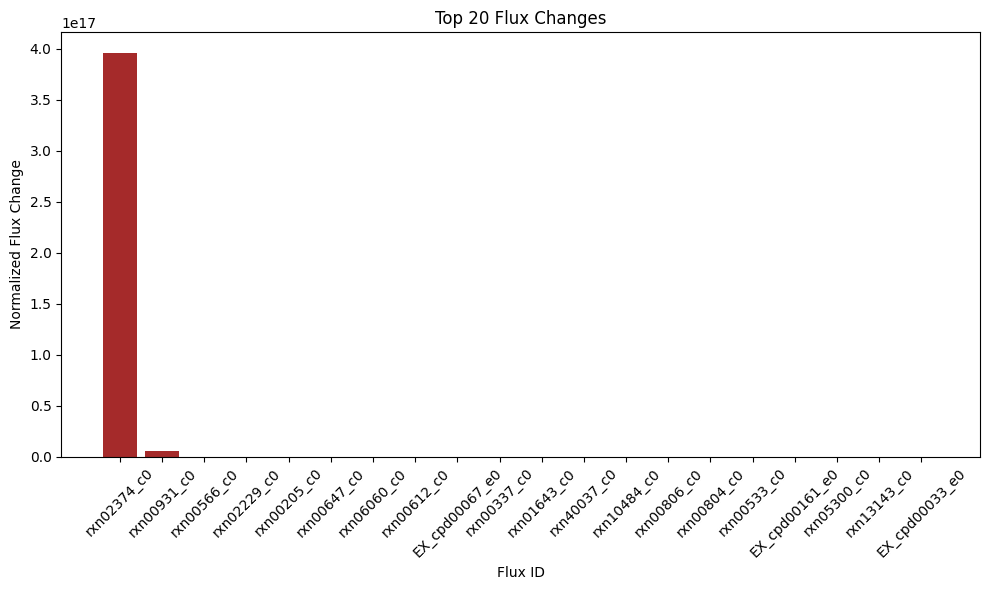

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 1289f0da-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:00
Completed in 0.064907 seconds
Set Exchange for Acetoacetate_e0 as zero. Flux ID: EX_cpd00142_e0
Number of Uptake Fluxes: 38

Uptake Fluxes:
EX_cpd00132_e0: -999.7997837125214
EX_cpd00023_e0: -706.5095613526948
EX_cpd00027_e0: -591.765960640979
EX_cpd00033_e0: -267.77537431529225
EX_cpd00007_e0: -213.48096910394855
EX_cpd00009_e0: -63.29367202624596
EX_cpd00107_e0: -29.240367772964117
EX_cpd00156_e0: -27.436691469056424
EX_cpd00039_e0: -22.23377905393826
EX_cpd00051_e0: -19.21608985316978
EX_cpd00322_e0: -18.834542942727783
EX_cpd00054_e0: -16.40451265697924
EX_cpd00129_e0: -14.360038265725795
EX_cpd00066_e0: -12.036070720306675
EX_cpd00060_e0: -9.95490575425944
EX_cpd03847_e0: -9.740820486282988
EX_cpd01080_e0: -9.704085206780423
EX_cpd00069_e0: -9.618510112397171
EX_cpd00084_e0: -6.805646882902878
EX_cpd00119_e0: -6.174122732606884
EX_cpd00065_e0: -3.6767247733501653
EX_cpd00220_e0: -0.655745047251181

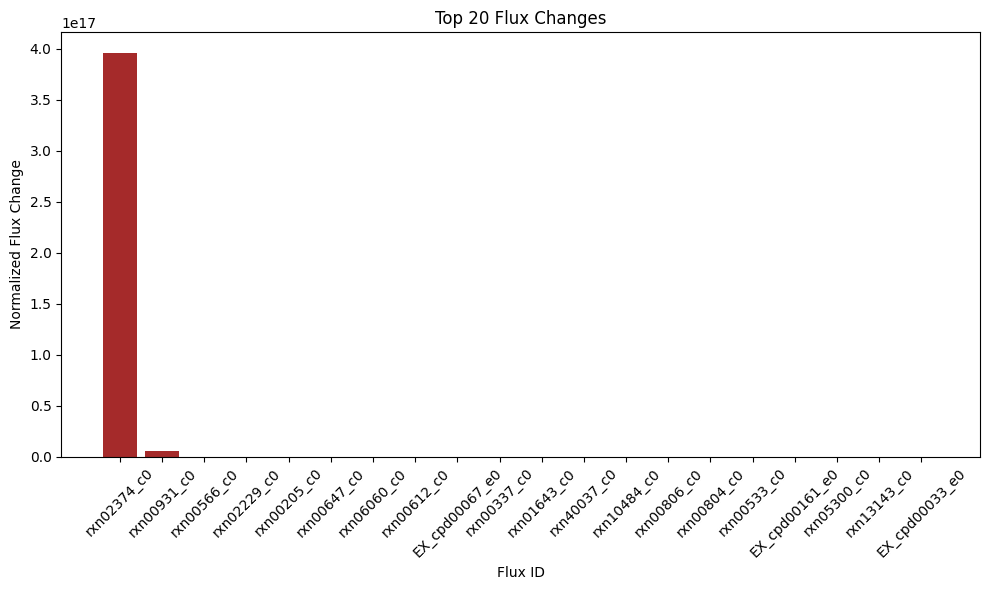

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 135d96e2-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:02
Completed in 0.043813 seconds
Set Exchange for Mg_e0 as zero. Flux ID: EX_cpd00254_e0
Number of Uptake Fluxes: 4

Uptake Fluxes:
EX_cpd00033_e0: -1.4761506276150627
EX_cpd00027_e0: -0.5271966527196654
EX_cpd00054_e0: -0.15815899581589948
EX_cpd00067_e0: -0.10543933054393173
Number of Secretion Fluxes: 6

Secretion Fluxes:
EX_cpd03847_e0: 1.4439219430427661e-16
EX_cpd00011_e0: 1.4439219430427666e-16
EX_cpd00075_e0: 0.15815899581589946
EX_cpd00001_e0: 0.4744769874476995
EX_cpd00047_e0: 0.6853556485355651
EX_cpd00161_e0: 1.4761506276150627
Objective flux for when eliminate 'EX_cpd00254_e0' (Exchange for Mg_e0): 0.0


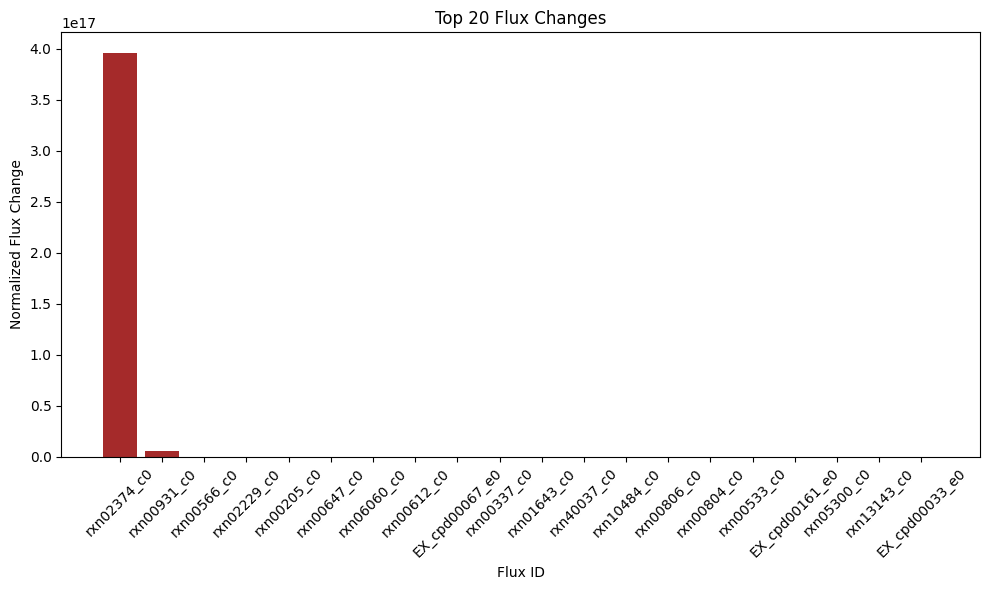

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 1462fe2e-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:03
Completed in 0.064523 seconds
Set Exchange for Acetate_e0 as zero. Flux ID: EX_cpd00029_e0
Number of Uptake Fluxes: 41

Uptake Fluxes:
EX_cpd00033_e0: -1000.0
EX_cpd00132_e0: -995.0984685518162
EX_cpd00023_e0: -736.9743125481435
EX_cpd00027_e0: -629.2832084674798
EX_cpd00067_e0: -278.44043152064745
EX_cpd00007_e0: -153.78835810726036
EX_cpd00009_e0: -59.86216235505345
EX_cpd00107_e0: -27.65508125710358
EX_cpd00156_e0: -25.949192496285747
EX_cpd00142_e0: -25.229520599167458
EX_cpd00039_e0: -21.02835953238832
EX_cpd00051_e0: -18.174276413327856
EX_cpd00322_e0: -17.813415329308718
EX_cpd00054_e0: -15.515130795701221
EX_cpd00129_e0: -13.581498980356379
EX_cpd00066_e0: -11.383526923149374
EX_cpd00060_e0: -9.415193737590432
EX_cpd03847_e0: -9.212715248680599
EX_cpd01080_e0: -9.177971597453846
EX_cpd00069_e0: -9.097036015277574
EX_cpd00084_e0: -6.436674087521426
EX_cpd00119_e0: -5.839388450491612
EX_cpd00065_

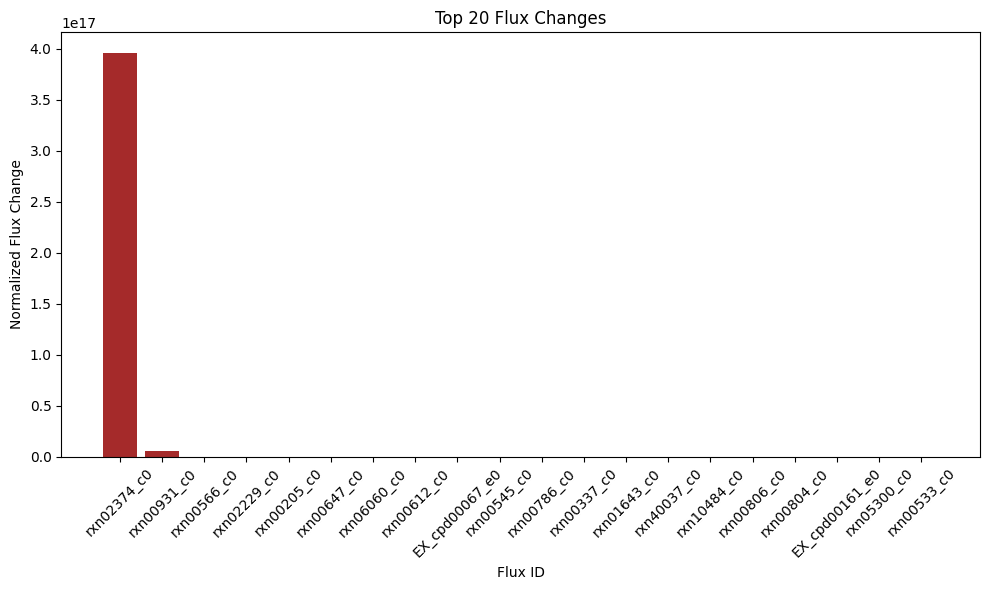

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 15379e4a-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:05
Completed in 0.065641 seconds
Set Exchange for L-Cysteine_e0 as zero. Flux ID: EX_cpd00084_e0
Number of Uptake Fluxes: 38

Uptake Fluxes:
EX_cpd00132_e0: -994.788472997038
EX_cpd00023_e0: -730.0146284785228
EX_cpd00027_e0: -568.1287691722769
EX_cpd00033_e0: -265.67459733754134
EX_cpd00007_e0: -214.6023446987826
EX_cpd00009_e0: -63.648122809679826
EX_cpd00107_e0: -29.40411670604046
EX_cpd00156_e0: -27.590339637577642
EX_cpd00142_e0: -26.825152355855657
EX_cpd00039_e0: -22.35829040162739
EX_cpd00051_e0: -19.323701844776295
EX_cpd00322_e0: -18.94001823413995
EX_cpd00054_e0: -16.49637953998409
EX_cpd00129_e0: -14.440455891229353
EX_cpd00066_e0: -12.103473899164909
EX_cpd00060_e0: -10.010654204784839
EX_cpd03847_e0: -9.795370038268844
EX_cpd01080_e0: -9.758429037590975
EX_cpd00069_e0: -9.672374714269429
EX_cpd00048_e0: -7.063564935579966
EX_cpd00119_e0: -6.2086984266609635
EX_cpd00065_e0: -3.697314793404842

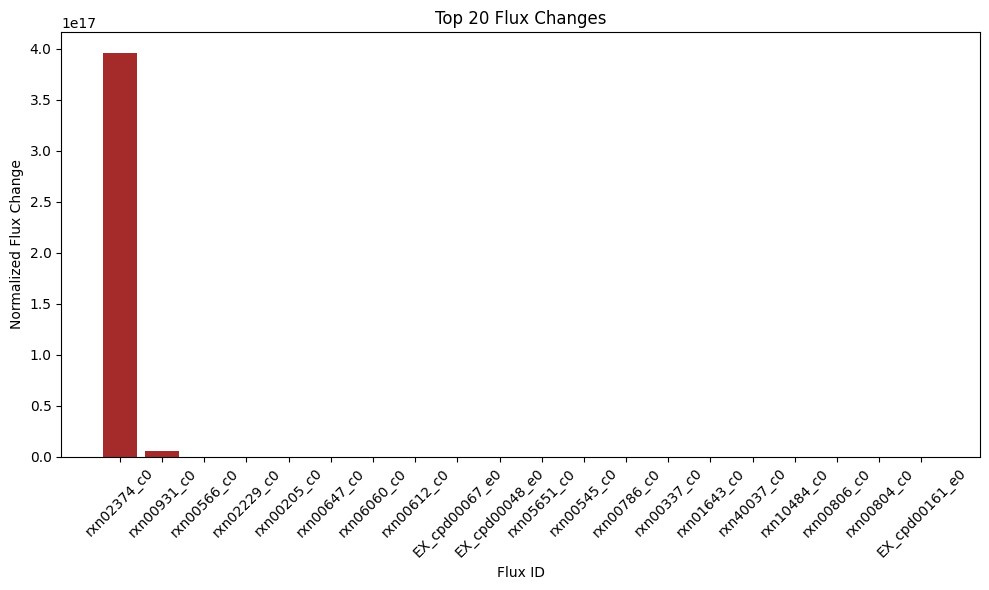

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 160f874c-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:06
Completed in 0.063636 seconds
Set Exchange for L-Glutamine_e0 as zero. Flux ID: EX_cpd00053_e0
Number of Uptake Fluxes: 40

Uptake Fluxes:
EX_cpd00041_e0: -696.9289177769042
EX_cpd00027_e0: -563.1088069554628
EX_cpd00033_e0: -306.97134503397064
EX_cpd00132_e0: -297.84497529381014
EX_cpd00007_e0: -209.41237626727926
EX_cpd00009_e0: -63.82618673817799
EX_cpd00023_e0: -44.70111069507742
EX_cpd00107_e0: -29.486378559236297
EX_cpd00156_e0: -27.66752721275903
EX_cpd00142_e0: -26.900199219772638
EX_cpd00039_e0: -22.420840636382472
EX_cpd00051_e0: -19.377762422084118
EX_cpd00322_e0: -18.993005406483178
EX_cpd00054_e0: -16.542530314229328
EX_cpd00129_e0: -14.480854950799316
EX_cpd00066_e0: -12.137334946684431
EX_cpd00060_e0: -10.038660316133907
EX_cpd03847_e0: -9.822773864071364
EX_cpd01080_e0: -9.78572951612388
EX_cpd00069_e0: -9.699434444604226
EX_cpd00084_e0: -6.862905483538489
EX_cpd00119_e0: -6.22606807063

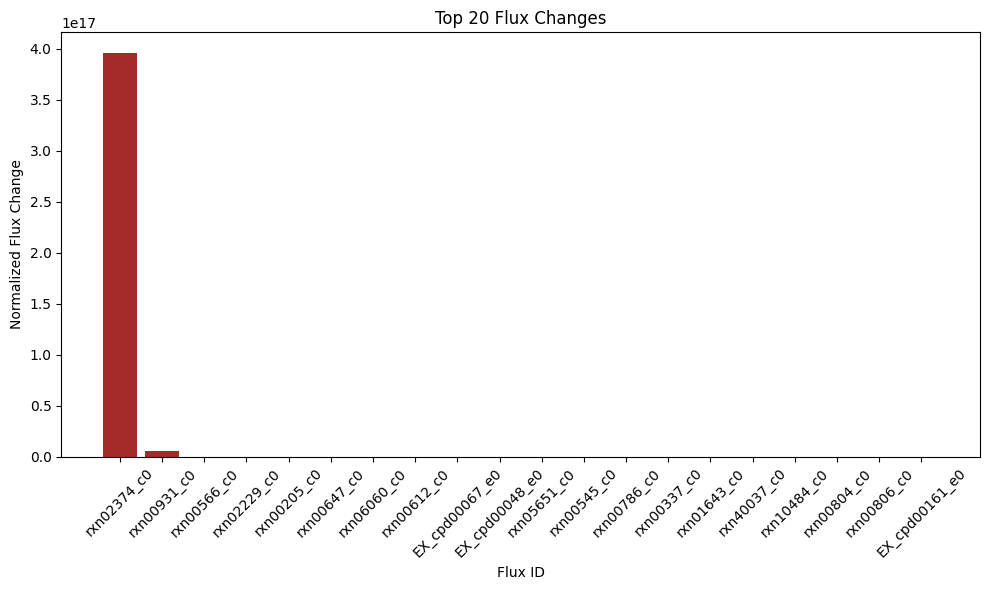

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 16e42376-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:07
Completed in 0.065537 seconds
Set Exchange for Putrescine_e0 as zero. Flux ID: EX_cpd00118_e0
Number of Uptake Fluxes: 38

Uptake Fluxes:
EX_cpd00132_e0: -994.3333294059968
EX_cpd00023_e0: -741.1855348383189
EX_cpd00027_e0: -563.2771411416473
EX_cpd00033_e0: -306.8106900786392
EX_cpd00007_e0: -209.4014829731809
EX_cpd00009_e0: -63.82305870832968
EX_cpd00107_e0: -29.484933474123036
EX_cpd00156_e0: -27.66617126694101
EX_cpd00142_e0: -26.89888087959934
EX_cpd00039_e0: -22.419741823146882
EX_cpd00051_e0: -19.597222639861556
EX_cpd00322_e0: -18.992074586534777
EX_cpd00054_e0: -16.54171958854985
EX_cpd00129_e0: -14.480145264871162
EX_cpd00066_e0: -12.136740113310406
EX_cpd00060_e0: -10.038168335792786
EX_cpd03847_e0: -9.822292464015554
EX_cpd01080_e0: -9.785249931558495
EX_cpd00069_e0: -9.698959089236567
EX_cpd00084_e0: -6.862569142386159
EX_cpd00119_e0: -6.225762939969028
EX_cpd00065_e0: -3.707476806947847


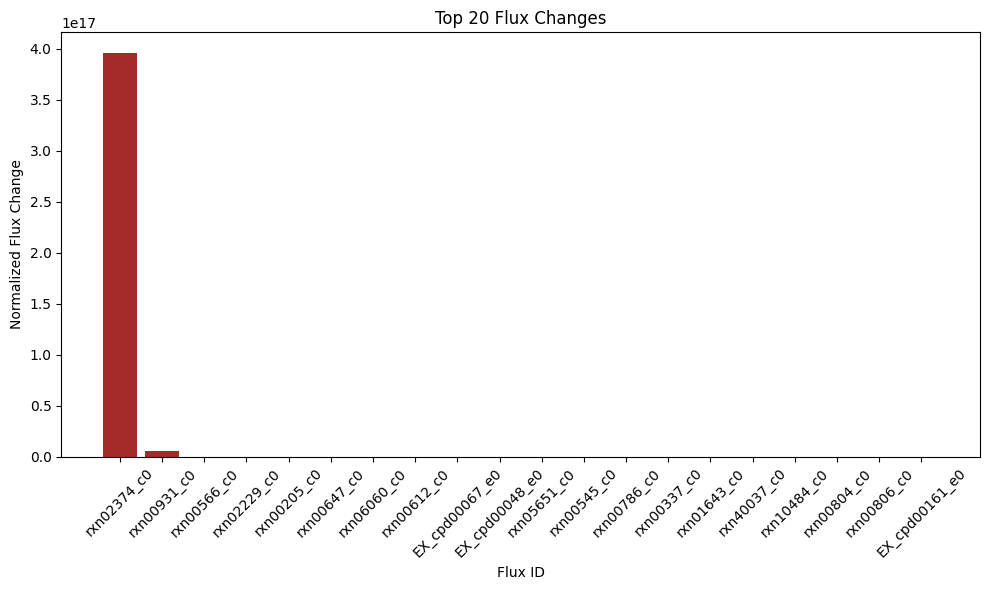

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 17b8d6b6-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:09
Completed in 0.063799 seconds
Set Exchange for D-Glucose_e0 as zero. Flux ID: EX_cpd00027_e0
Number of Uptake Fluxes: 40

Uptake Fluxes:
EX_cpd00041_e0: -982.3340447789491
EX_cpd00023_e0: -836.9226248811952
EX_cpd00067_e0: -828.5555242951391
EX_cpd00007_e0: -626.102965839712
EX_cpd00033_e0: -169.2169293329692
EX_cpd00054_e0: -136.49482621521184
EX_cpd00009_e0: -53.68995737922328
EX_cpd00107_e0: -24.803650178997827
EX_cpd00156_e0: -23.273650405204314
EX_cpd00142_e0: -22.62818168233833
EX_cpd00039_e0: -18.86018951926165
EX_cpd00051_e0: -16.300382205414945
EX_cpd00322_e0: -15.976728407112487
EX_cpd00132_e0: -13.269805730400977
EX_cpd00129_e0: -12.181152045201577
EX_cpd00066_e0: -10.209806182814033
EX_cpd00060_e0: -8.444421828436989
EX_cpd03847_e0: -8.262820278942302
EX_cpd01080_e0: -8.23165893962249
EX_cpd00069_e0: -8.15906837846411
EX_cpd00084_e0: -5.773008254752133
EX_cpd00119_e0: -5.237306917985297
EX_

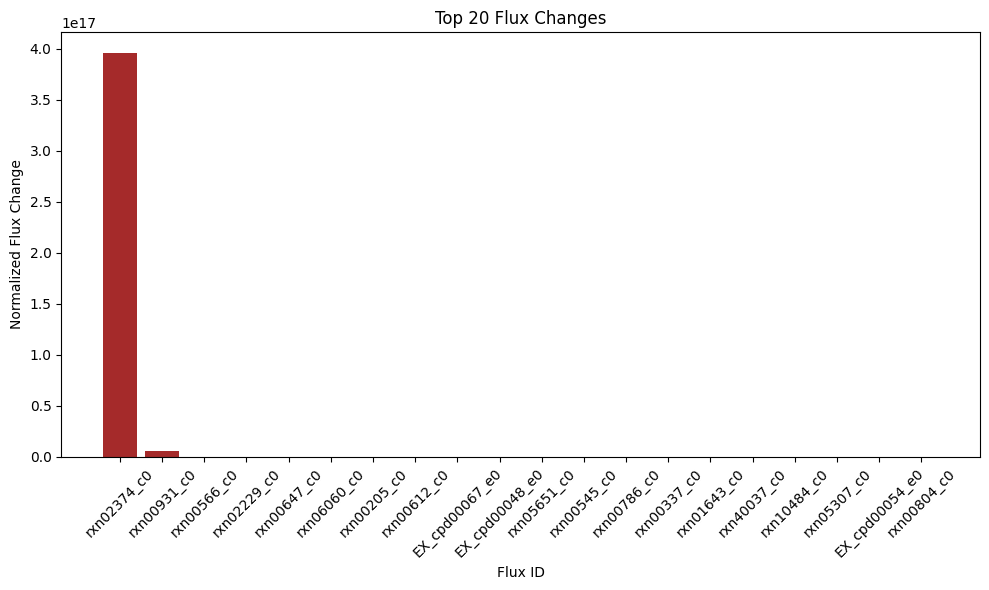

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 18c45224-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:11
Completed in 0.063406 seconds
Set Exchange for L-Valine_e0 as zero. Flux ID: EX_cpd00156_e0
Number of Uptake Fluxes: 40

Uptake Fluxes:
EX_cpd00041_e0: -623.5467511348888
EX_cpd00027_e0: -594.5148773282584
EX_cpd00132_e0: -343.8603782131994
EX_cpd00007_e0: -277.7235271806844
EX_cpd00033_e0: -81.48186929250303
EX_cpd00009_e0: -63.24259093865633
EX_cpd00023_e0: -44.292385346299476
EX_cpd00107_e0: -29.21676936668114
EX_cpd00142_e0: -26.65423680100256
EX_cpd00039_e0: -22.215835307286557
EX_cpd00051_e0: -19.200581529230554
EX_cpd00322_e0: -18.81934254579819
EX_cpd00054_e0: -16.391273413288488
EX_cpd00129_e0: -14.34844901281852
EX_cpd00066_e0: -12.026357022821276
EX_cpd00060_e0: -9.946871658644715
EX_cpd03847_e0: -9.732959167945634
EX_cpd01080_e0: -9.696253535609518
EX_cpd00069_e0: -9.610747504510991
EX_cpd00084_e0: -6.8001543931570145
EX_cpd00119_e0: -6.169139913723884
EX_cpd00065_e0: -3.673757476711974
EX_

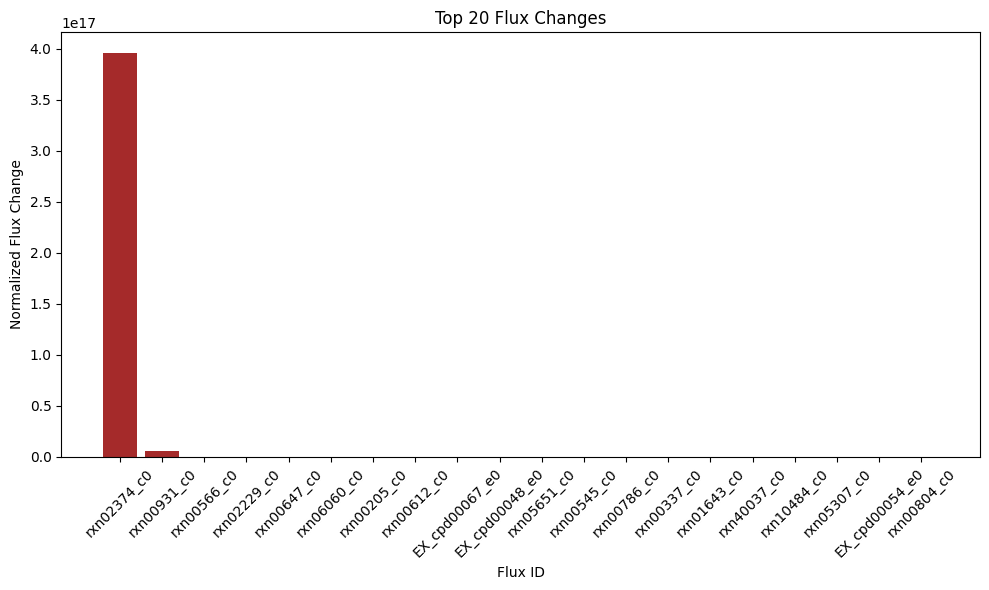

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 19976970-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:12
Completed in 0.054044 seconds
Set Exchange for Phosphate_e0 as zero. Flux ID: EX_cpd00009_e0
Number of Uptake Fluxes: 10

Uptake Fluxes:
EX_cpd00033_e0: -1.4761506276150407
EX_cpd00027_e0: -0.5271966527196559
EX_cpd00054_e0: -0.15815899581589754
EX_cpd00067_e0: -0.10543933054393291
EX_cpd00011_e0: -2.2984068145210096e-15
EX_cpd00053_e0: -1.1416738141064038e-15
EX_cpd00393_e0: -7.303257904414635e-17
EX_cpd00100_e0: -3.414669941111542e-17
EX_cpd00218_e0: -3.076577687531465e-18
EX_cpd00214_e0: -2.2897928826597456e-31
Number of Secretion Fluxes: 35

Secretion Fluxes:
EX_cpd00017_e0: 3.0765776875314295e-18
EX_cpd00099_e0: 3.0765776875314295e-18
EX_cpd00030_e0: 3.0765776875314646e-18
EX_cpd00034_e0: 3.0765776875314646e-18
EX_cpd00058_e0: 3.0765776875314646e-18
EX_cpd00063_e0: 3.0765776875314646e-18
EX_cpd00149_e0: 3.0765776875314646e-18
EX_cpd00205_e0: 3.0765776875314646e-18
EX_cpd00264_e0: 3.076577687531464

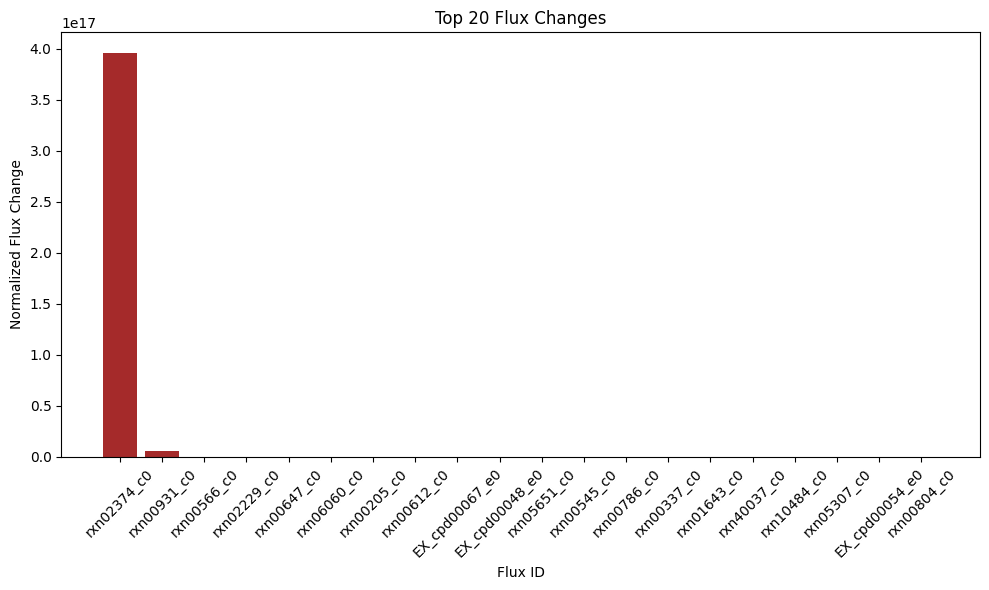

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 1a687e3e-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:13
Completed in 0.066467 seconds
Set Exchange for Formate_e0 as zero. Flux ID: EX_cpd00047_e0
Number of Uptake Fluxes: 38

Uptake Fluxes:
EX_cpd00132_e0: -766.6204535554235
EX_cpd00027_e0: -738.1681211859943
EX_cpd00033_e0: -354.1908511769018
EX_cpd00007_e0: -196.63309282016348
EX_cpd00041_e0: -162.57031072118752
EX_cpd00009_e0: -57.676185951509666
EX_cpd00053_e0: -40.39391516939375
EX_cpd00107_e0: -26.645205357406994
EX_cpd00142_e0: -24.308218485565703
EX_cpd00039_e0: -20.260470503081667
EX_cpd00051_e0: -17.51060945196142
EX_cpd00322_e0: -17.16292587078529
EX_cpd00129_e0: -13.085545691537938
EX_cpd00066_e0: -10.967836606192419
EX_cpd00060_e0: -9.071380708868544
EX_cpd03847_e0: -8.87629609250763
EX_cpd01080_e0: -8.842821169284784
EX_cpd00069_e0: -8.76484109800027
EX_cpd00084_e0: -6.2016271543821215
EX_cpd00119_e0: -5.6261524953955355
EX_cpd00065_e0: -3.3504054186063286
EX_cpd00220_e0: -0.5975458852561175


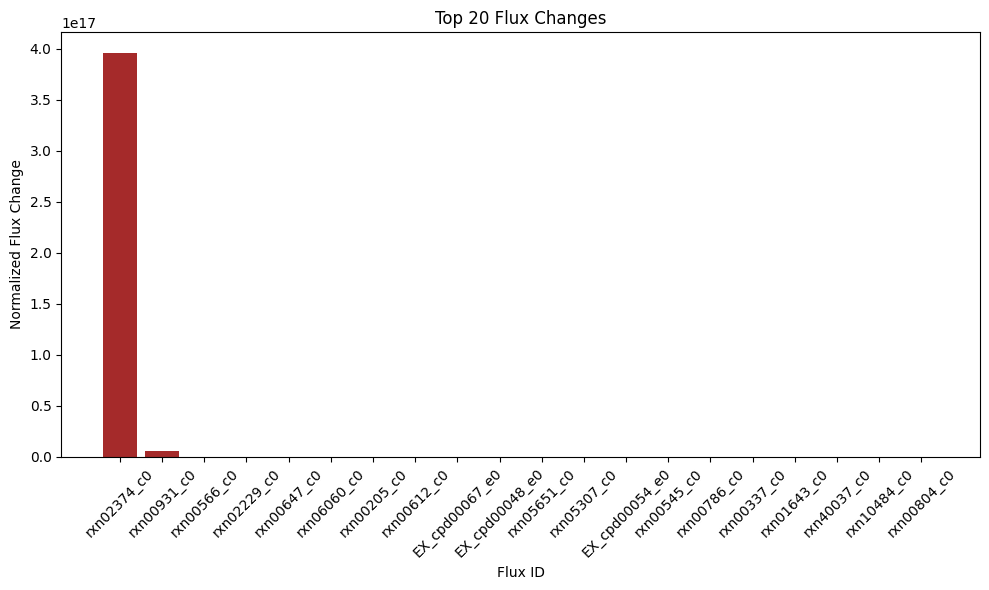

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 1b3c5056-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:15
Completed in 0.064287 seconds
Set Exchange for Butyrate_e0 as zero. Flux ID: EX_cpd00211_e0
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00132_e0: -994.7738930702296
EX_cpd00023_e0: -741.630028473323
EX_cpd00027_e0: -563.1088069548878
EX_cpd00033_e0: -306.9713450328153
EX_cpd00007_e0: -209.41237626732632
EX_cpd00009_e0: -63.82618673815166
EX_cpd00107_e0: -29.486378559216636
EX_cpd00156_e0: -27.66752721274058
EX_cpd00142_e0: -26.90019921975526
EX_cpd00039_e0: -22.42084063636752
EX_cpd00051_e0: -19.377762422071196
EX_cpd00322_e0: -18.993005406470512
EX_cpd00054_e0: -16.542530314218297
EX_cpd00129_e0: -14.480854950789103
EX_cpd00066_e0: -12.137334946676337
EX_cpd00060_e0: -10.038660316127144
EX_cpd03847_e0: -9.822773864064747
EX_cpd01080_e0: -9.785729516117355
EX_cpd00069_e0: -9.699434444597827
EX_cpd00084_e0: -6.86290548353411
EX_cpd00119_e0: -6.226068070629362
EX_cpd00065_e0: -3.707658513970292
EX_

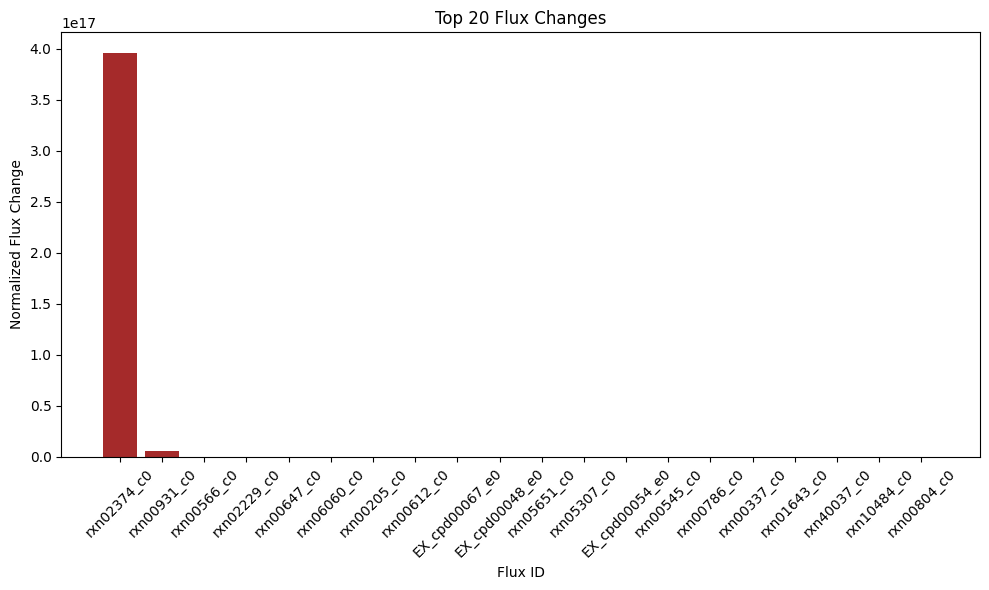

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 1c10e230-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:16
Completed in 0.065274 seconds
Set Exchange for Thiamin_e0 as zero. Flux ID: EX_cpd00305_e0
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00132_e0: -994.7738930702296
EX_cpd00023_e0: -741.630028473323
EX_cpd00027_e0: -563.1088069548878
EX_cpd00033_e0: -306.9713450328153
EX_cpd00007_e0: -209.41237626732632
EX_cpd00009_e0: -63.82618673815166
EX_cpd00107_e0: -29.486378559216636
EX_cpd00156_e0: -27.66752721274058
EX_cpd00142_e0: -26.90019921975526
EX_cpd00039_e0: -22.42084063636752
EX_cpd00051_e0: -19.377762422071196
EX_cpd00322_e0: -18.993005406470512
EX_cpd00054_e0: -16.542530314218297
EX_cpd00129_e0: -14.480854950789103
EX_cpd00066_e0: -12.137334946676337
EX_cpd00060_e0: -10.038660316127144
EX_cpd03847_e0: -9.822773864064747
EX_cpd01080_e0: -9.785729516117355
EX_cpd00069_e0: -9.699434444597827
EX_cpd00084_e0: -6.86290548353411
EX_cpd00119_e0: -6.226068070629362
EX_cpd00065_e0: -3.707658513970292
EX_c

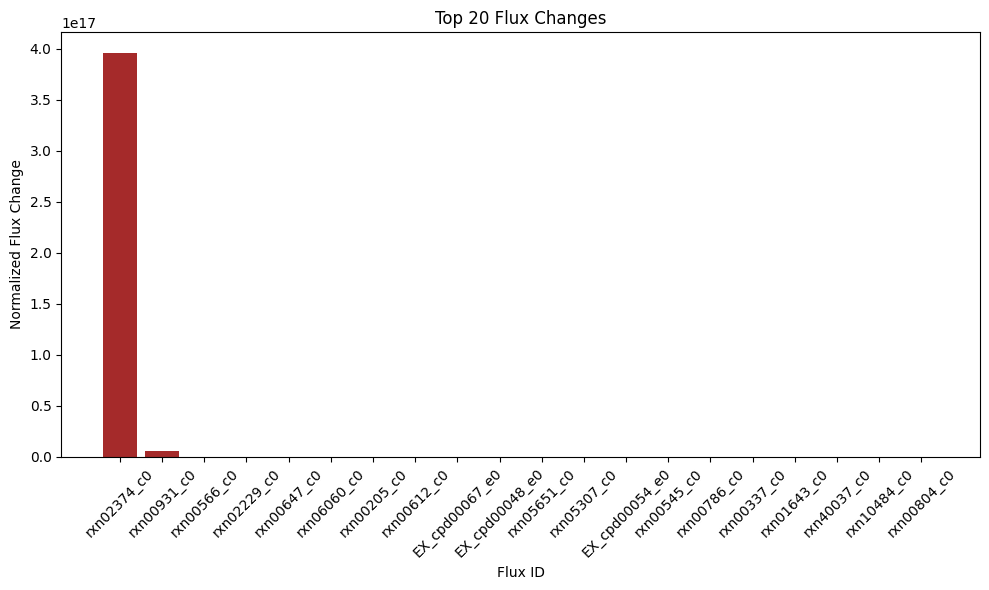

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 1d1d3f66-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:18
Completed in 0.063334 seconds
Set Exchange for Palmitate_e0 as zero. Flux ID: EX_cpd00214_e0
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00132_e0: -994.7738930702196
EX_cpd00023_e0: -741.6300284733178
EX_cpd00027_e0: -563.1088069548928
EX_cpd00033_e0: -306.97134503290823
EX_cpd00007_e0: -209.41237626731018
EX_cpd00009_e0: -63.826186738123276
EX_cpd00107_e0: -29.486378559218103
EX_cpd00156_e0: -27.667527212741955
EX_cpd00142_e0: -26.90019921975659
EX_cpd00039_e0: -22.420840636368634
EX_cpd00051_e0: -19.377762422072166
EX_cpd00322_e0: -18.993005406471468
EX_cpd00054_e0: -16.54253031421912
EX_cpd00129_e0: -14.48085495079034
EX_cpd00066_e0: -12.13733494667694
EX_cpd00060_e0: -10.038660316127643
EX_cpd03847_e0: -9.822773864065239
EX_cpd01080_e0: -9.785729516117842
EX_cpd00069_e0: -9.699434444598309
EX_cpd00084_e0: -6.862905483534424
EX_cpd00119_e0: -6.226068070629672
EX_cpd00065_e0: -3.707658513970476

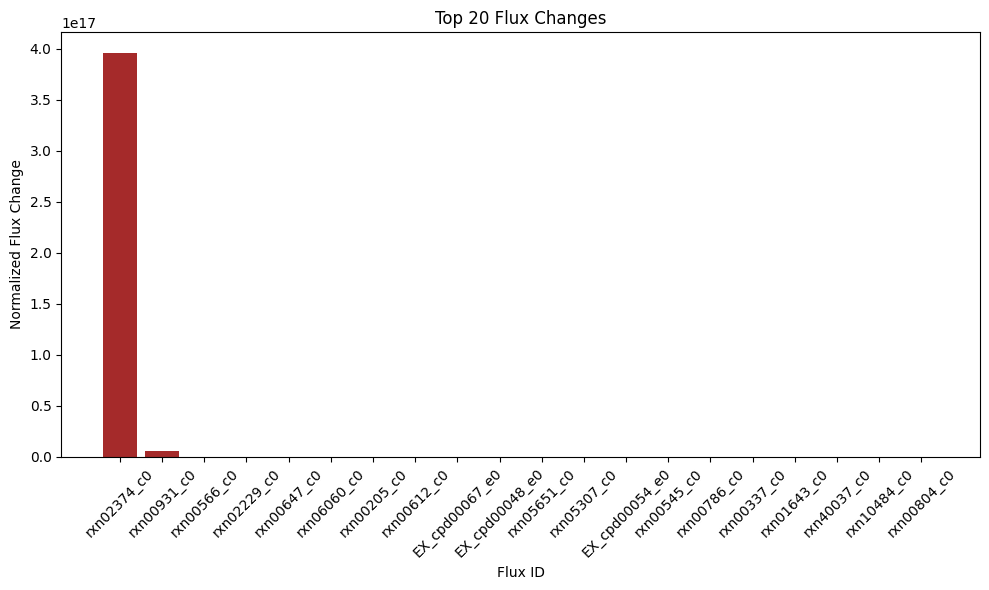

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 1df381a2-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:19
Completed in 0.065650 seconds
Set Exchange for L-Proline_e0 as zero. Flux ID: EX_cpd00129_e0
Number of Uptake Fluxes: 38

Uptake Fluxes:
EX_cpd00132_e0: -994.7878782613777
EX_cpd00023_e0: -755.8715284920655
EX_cpd00027_e0: -562.6723237610108
EX_cpd00033_e0: -281.9054141162286
EX_cpd00007_e0: -209.74334338614236
EX_cpd00009_e0: -63.65538628681613
EX_cpd00107_e0: -29.407472282298762
EX_cpd00156_e0: -27.59348822692559
EX_cpd00142_e0: -26.82821362259155
EX_cpd00039_e0: -22.360841913349304
EX_cpd00051_e0: -19.325907051475113
EX_cpd00322_e0: -18.942179655146187
EX_cpd00054_e0: -16.498262094732656
EX_cpd00066_e0: -12.104855138739797
EX_cpd00060_e0: -10.011796613309315
EX_cpd03847_e0: -9.796487878721964
EX_cpd01080_e0: -9.759542662364138
EX_cpd00069_e0: -9.673478518586256
EX_cpd00084_e0: -6.844540179044163
EX_cpd00119_e0: -6.209406958777189
EX_cpd00065_e0: -3.6977367282605718
EX_cpd00220_e0: -0.659492536175420

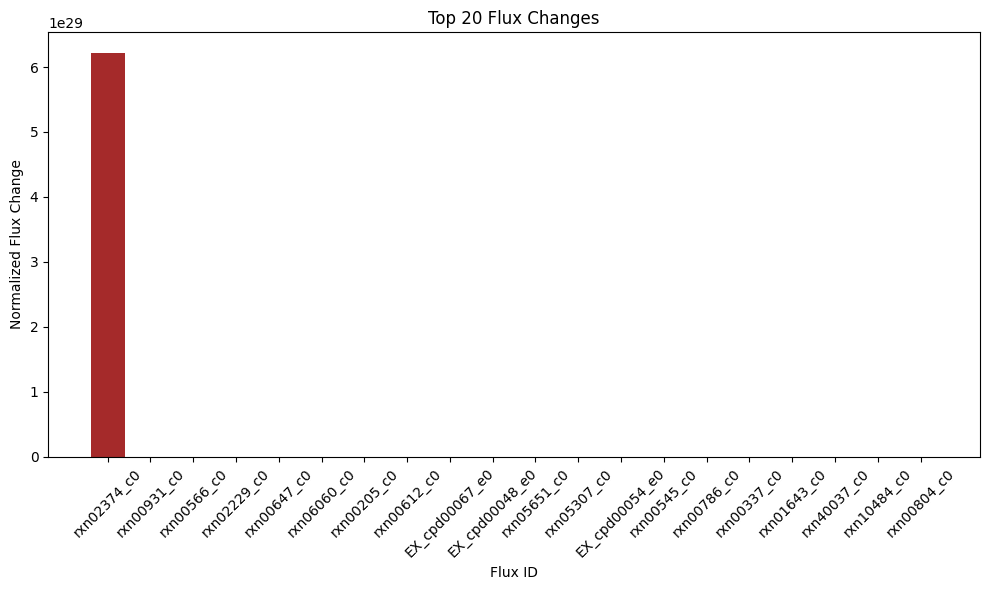

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 1ec80dd2-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:21
Completed in 0.065387 seconds
Set Exchange for Riboflavin_e0 as zero. Flux ID: EX_cpd00220_e0
Number of Uptake Fluxes: 38

Uptake Fluxes:
EX_cpd00132_e0: -995.4438638848679
EX_cpd00023_e0: -741.4870147871379
EX_cpd00027_e0: -563.061631271439
EX_cpd00033_e0: -307.06360770988175
EX_cpd00007_e0: -209.4452509680341
EX_cpd00009_e0: -63.70442034425598
EX_cpd00107_e0: -29.43012500296894
EX_cpd00156_e0: -27.614743626747785
EX_cpd00142_e0: -26.84887952761863
EX_cpd00039_e0: -22.378066579956165
EX_cpd00051_e0: -19.34079389281708
EX_cpd00322_e0: -18.9567709093857
EX_cpd00054_e0: -16.510970787244133
EX_cpd00129_e0: -14.45322864914403
EX_cpd00066_e0: -12.114179568244605
EX_cpd00060_e0: -10.019508749527986
EX_cpd03847_e0: -9.804034161562425
EX_cpd01080_e0: -9.767060486122567
EX_cpd00069_e0: -9.680930046711044
EX_cpd00084_e0: -6.84981256203935
EX_cpd00119_e0: -6.214190095526052
EX_cpd00065_e0: -3.7005851130660745
EX_

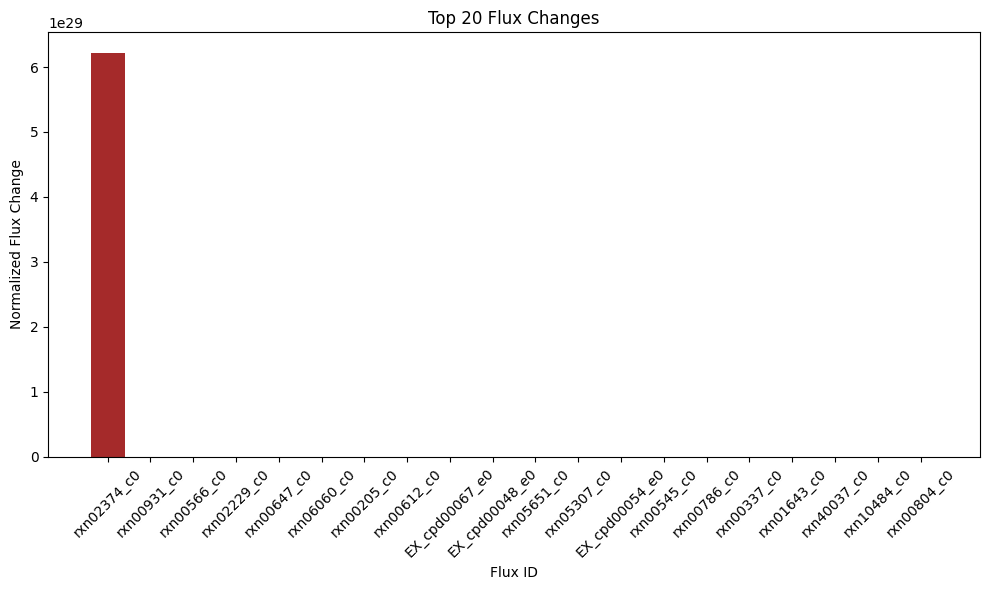

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 1f9c563c-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:22
Completed in 0.065011 seconds
Set Exchange for Spermidine_e0 as zero. Flux ID: EX_cpd00264_e0
Number of Uptake Fluxes: 38

Uptake Fluxes:
EX_cpd00132_e0: -994.7742345633135
EX_cpd00023_e0: -741.4047237974604
EX_cpd00027_e0: -563.1863113416964
EX_cpd00033_e0: -306.38979810396575
EX_cpd00007_e0: -209.47132087690906
EX_cpd00009_e0: -63.822016099852696
EX_cpd00107_e0: -29.48445181056735
EX_cpd00156_e0: -27.665719314541786
EX_cpd00142_e0: -26.898441461595564
EX_cpd00039_e0: -22.419375576006676
EX_cpd00051_e0: -19.376496207656363
EX_cpd00322_e0: -18.99176433349713
EX_cpd00054_e0: -16.541449364318847
EX_cpd00129_e0: -14.4799087183571
EX_cpd00066_e0: -12.136541848477878
EX_cpd00060_e0: -10.038004353063863
EX_cpd03847_e0: -9.822132007817906
EX_cpd01080_e0: -9.785090080484741
EX_cpd00069_e0: -9.698800647803235
EX_cpd00084_e0: -6.862457035996022
EX_cpd00119_e0: -6.225661236394993
EX_cpd00065_e0: -3.70741624189814

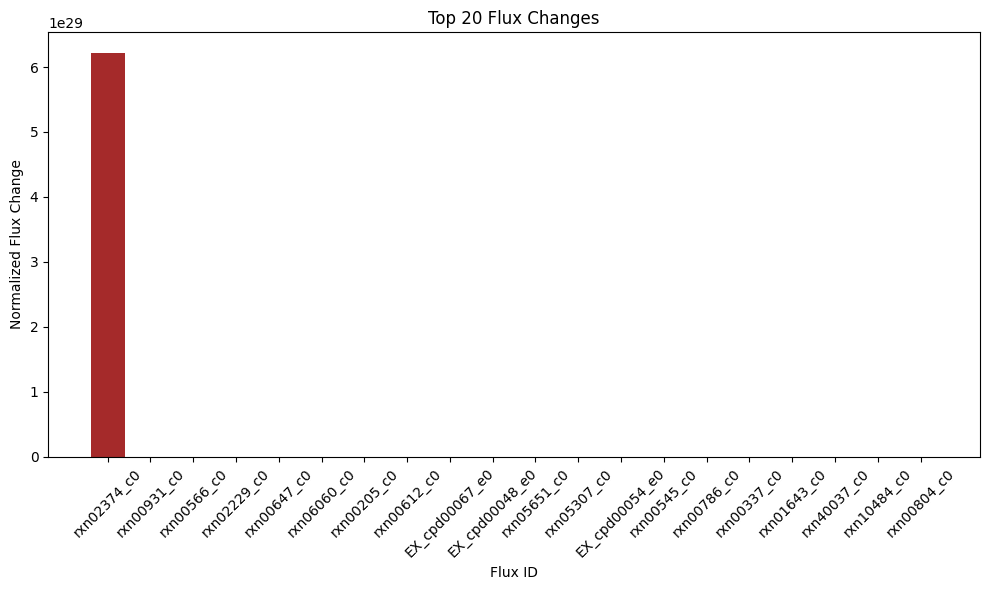

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 2071bac0-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:23
Completed in 0.065382 seconds
Set Exchange for L-Aspartate_e0 as zero. Flux ID: EX_cpd00041_e0
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00132_e0: -994.7738930702296
EX_cpd00023_e0: -741.630028473323
EX_cpd00027_e0: -563.1088069548878
EX_cpd00033_e0: -306.9713450328153
EX_cpd00007_e0: -209.41237626732632
EX_cpd00009_e0: -63.82618673815166
EX_cpd00107_e0: -29.486378559216636
EX_cpd00156_e0: -27.66752721274058
EX_cpd00142_e0: -26.90019921975526
EX_cpd00039_e0: -22.42084063636752
EX_cpd00051_e0: -19.377762422071196
EX_cpd00322_e0: -18.993005406470512
EX_cpd00054_e0: -16.542530314218297
EX_cpd00129_e0: -14.480854950789103
EX_cpd00066_e0: -12.137334946676337
EX_cpd00060_e0: -10.038660316127144
EX_cpd03847_e0: -9.822773864064747
EX_cpd01080_e0: -9.785729516117355
EX_cpd00069_e0: -9.699434444597827
EX_cpd00084_e0: -6.86290548353411
EX_cpd00119_e0: -6.226068070629362
EX_cpd00065_e0: -3.707658513970292


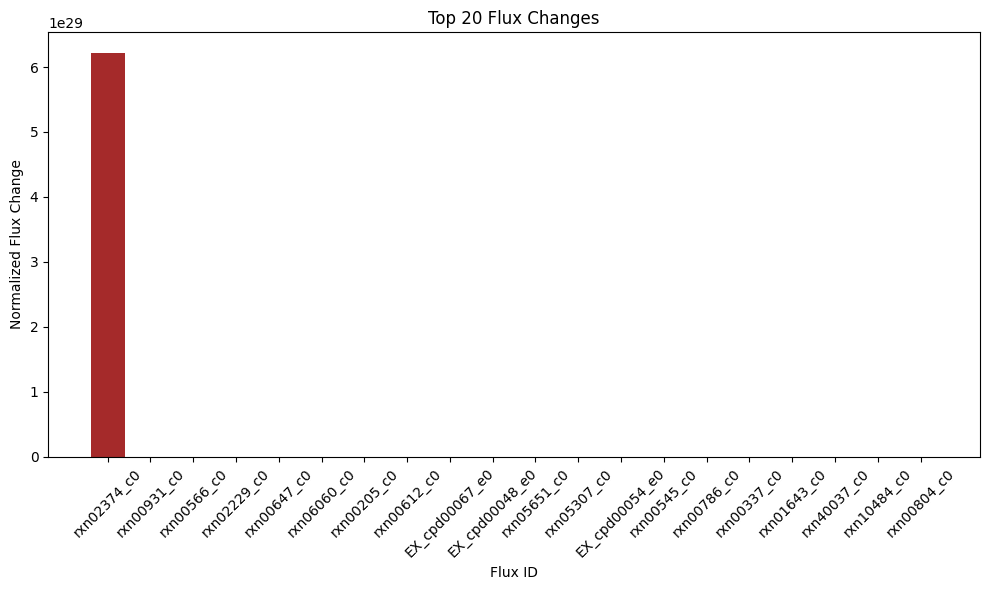

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 217eefd2-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:25
Completed in 0.042616 seconds
Set Exchange for K+_e0 as zero. Flux ID: EX_cpd00205_e0
Number of Uptake Fluxes: 4

Uptake Fluxes:
EX_cpd00033_e0: -1.4761506276150624
EX_cpd00027_e0: -0.527196652719665
EX_cpd00054_e0: -0.15815899581589965
EX_cpd00067_e0: -0.10543933054393466
Number of Secretion Fluxes: 4

Secretion Fluxes:
EX_cpd00075_e0: 0.15815899581589962
EX_cpd00001_e0: 0.4744769874476987
EX_cpd00047_e0: 0.6853556485355647
EX_cpd00161_e0: 1.4761506276150627
Objective flux for when eliminate 'EX_cpd00205_e0' (Exchange for K+_e0): 0.0


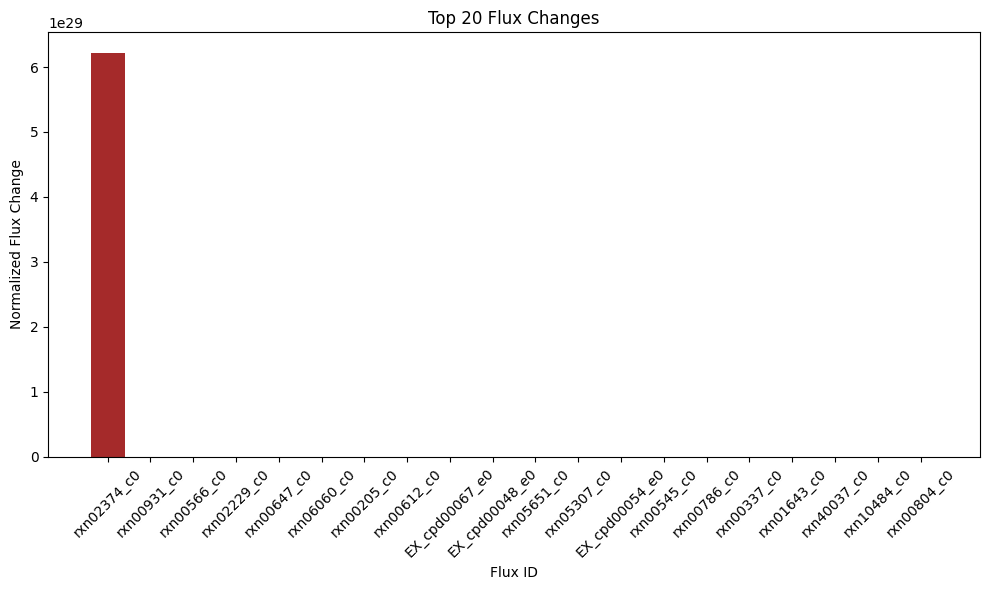

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 224f7fc6-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:27
Completed in 0.065405 seconds
Set Exchange for NH3_e0 as zero. Flux ID: EX_cpd00013_e0
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00132_e0: -994.7738930702296
EX_cpd00023_e0: -741.630028473323
EX_cpd00027_e0: -563.1088069548878
EX_cpd00033_e0: -306.9713450328153
EX_cpd00007_e0: -209.41237626732632
EX_cpd00009_e0: -63.82618673815166
EX_cpd00107_e0: -29.486378559216636
EX_cpd00156_e0: -27.66752721274058
EX_cpd00142_e0: -26.90019921975526
EX_cpd00039_e0: -22.42084063636752
EX_cpd00051_e0: -19.377762422071196
EX_cpd00322_e0: -18.993005406470512
EX_cpd00054_e0: -16.542530314218297
EX_cpd00129_e0: -14.480854950789103
EX_cpd00066_e0: -12.137334946676337
EX_cpd00060_e0: -10.038660316127144
EX_cpd03847_e0: -9.822773864064747
EX_cpd01080_e0: -9.785729516117355
EX_cpd00069_e0: -9.699434444597827
EX_cpd00084_e0: -6.86290548353411
EX_cpd00119_e0: -6.226068070629362
EX_cpd00065_e0: -3.707658513970292
EX_cpd00

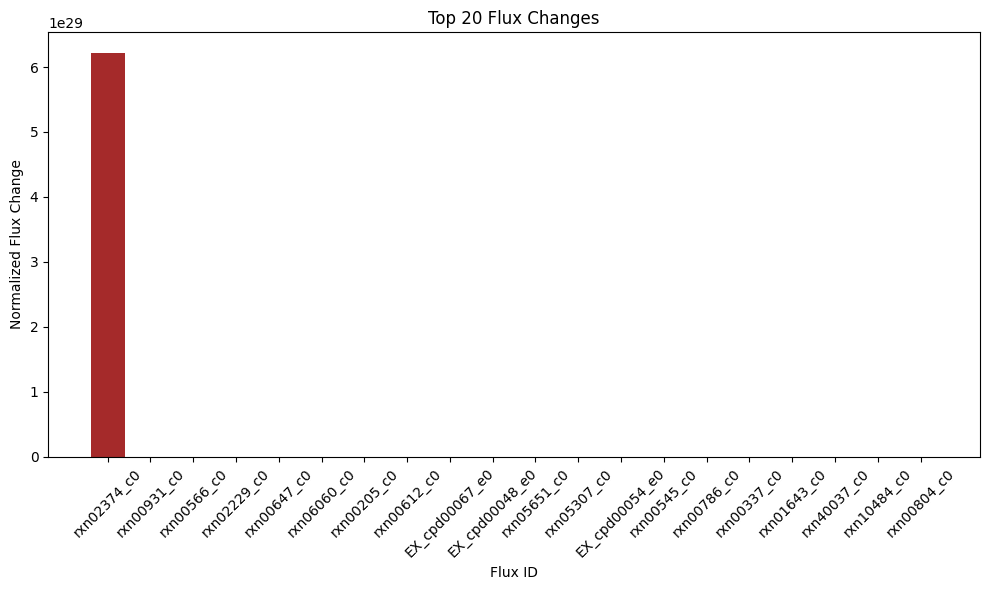

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 23230968-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:28
Completed in 0.048919 seconds
Set Exchange for Cl-_e0 as zero. Flux ID: EX_cpd00099_e0
Number of Uptake Fluxes: 10

Uptake Fluxes:
EX_cpd00033_e0: -1.4761506276150627
EX_cpd00027_e0: -0.5271966527196651
EX_cpd00054_e0: -0.15815899581589954
EX_cpd00067_e0: -0.10543933054393674
EX_cpd00053_e0: -1.4129967928566466e-16
EX_cpd00119_e0: -1.412996792856641e-16
EX_cpd00011_e0: -1.0520163070959667e-16
EX_cpd00393_e0: -7.288510338826695e-32
EX_cpd00100_e0: -3.4077746527927124e-32
EX_cpd00218_e0: -3.0703651133861862e-33
Number of Secretion Fluxes: 34

Secretion Fluxes:
EX_cpd00017_e0: 1.0225621649753047e-33
EX_cpd00048_e0: 3.0703651133861865e-33
EX_cpd00030_e0: 3.070365113386187e-33
EX_cpd00034_e0: 3.070365113386187e-33
EX_cpd00058_e0: 3.070365113386187e-33
EX_cpd00063_e0: 3.070365113386187e-33
EX_cpd00104_e0: 3.070365113386187e-33
EX_cpd00149_e0: 3.070365113386187e-33
EX_cpd00205_e0: 3.070365113386187e-33
EX_cpd

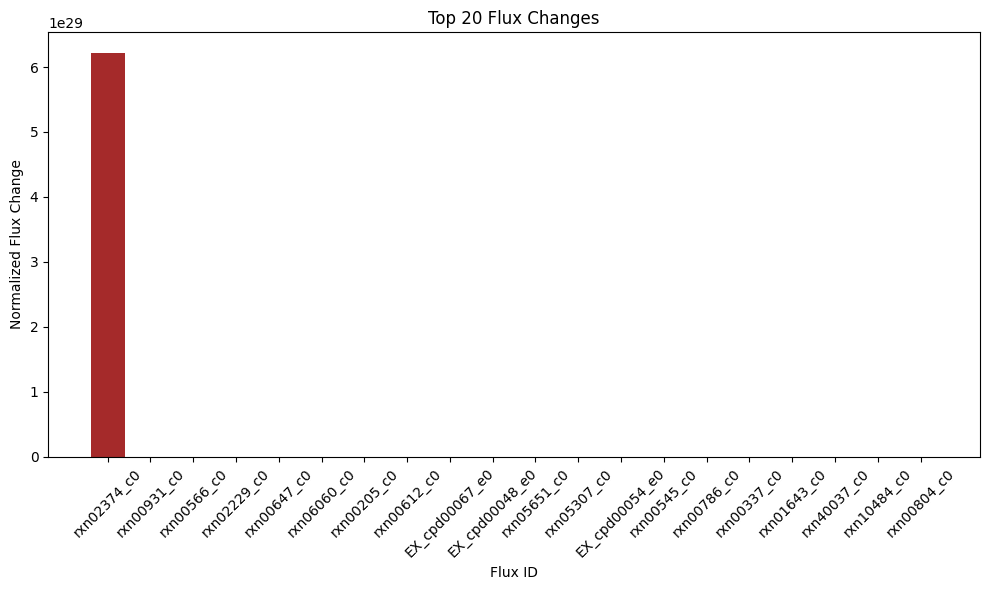

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 23f428ae-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:29
Completed in 0.066809 seconds
Set Exchange for BIOT_e0 as zero. Flux ID: EX_cpd00104_e0
Number of Uptake Fluxes: 38

Uptake Fluxes:
EX_cpd00132_e0: -994.3360127169152
EX_cpd00023_e0: -741.7377296804128
EX_cpd00027_e0: -563.2879475223739
EX_cpd00033_e0: -305.749954430871
EX_cpd00007_e0: -209.60127456970167
EX_cpd00009_e0: -63.79283688632808
EX_cpd00107_e0: -29.47097161724114
EX_cpd00156_e0: -27.653070639665113
EX_cpd00142_e0: -26.886143583601907
EX_cpd00039_e0: -22.409125512042145
EX_cpd00051_e0: -19.367637338020874
EX_cpd00322_e0: -18.983081361995197
EX_cpd00054_e0: -16.53388666867305
EX_cpd00129_e0: -14.473288552239278
EX_cpd00066_e0: -12.130993061901133
EX_cpd00060_e0: -10.033415010851975
EX_cpd03847_e0: -9.817641361724453
EX_cpd01080_e0: -9.780616369837286
EX_cpd00069_e0: -9.694366388397471
EX_cpd00084_e0: -7.079625067950216
EX_cpd00119_e0: -6.2228148847792575
EX_cpd00065_e0: -3.70572122352023
EX_cp

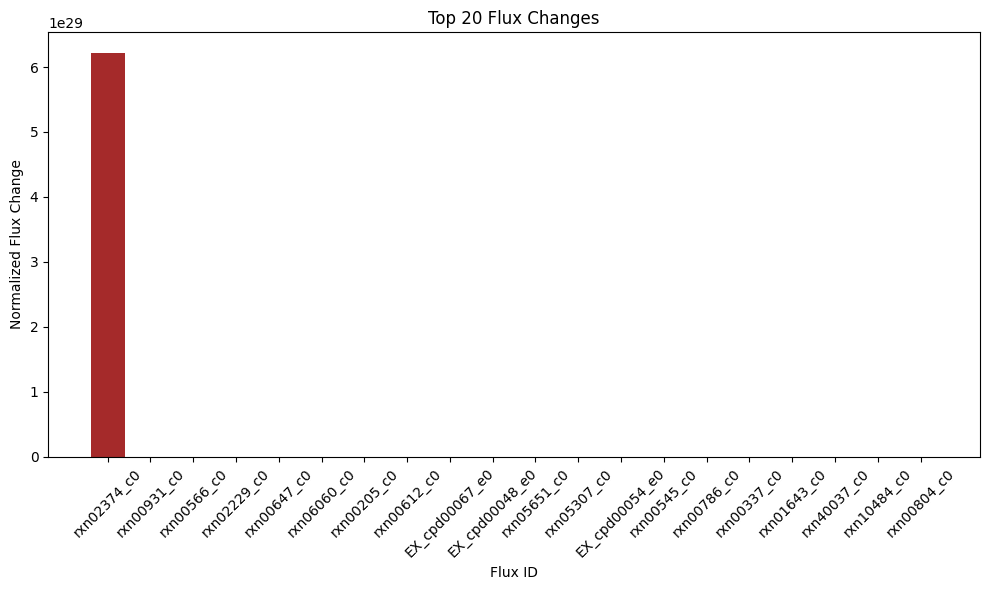

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 251b8e20-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:31
Completed in 0.070124 seconds
Set Exchange for CO2_e0 as zero. Flux ID: EX_cpd00011_e0
Number of Uptake Fluxes: 38

Uptake Fluxes:
EX_cpd00027_e0: -648.968137232789
EX_cpd00033_e0: -371.4213747550134
EX_cpd00053_e0: -369.20731157509636
EX_cpd00007_e0: -248.166311585966
EX_cpd00132_e0: -65.20567847935746
EX_cpd00009_e0: -51.73786912298987
EX_cpd00107_e0: -23.90182576732473
EX_cpd00156_e0: -22.42745454561547
EX_cpd00039_e0: -18.174460636838827
EX_cpd00051_e0: -15.707724169748417
EX_cpd00322_e0: -15.395837949771469
EX_cpd00054_e0: -13.409468935870509
EX_cpd00129_e0: -11.738263188231041
EX_cpd00066_e0: -9.838592575636621
EX_cpd00060_e0: -8.137395012127058
EX_cpd03847_e0: -7.962396229133547
EX_cpd01080_e0: -7.93236787049573
EX_cpd00069_e0: -7.862416595879587
EX_cpd00084_e0: -5.563110125430504
EX_cpd00119_e0: -5.046886105081611
EX_cpd00065_e0: -3.005449028868823
EX_cpd00220_e0: -0.5360228020689808
EX_cpd1051

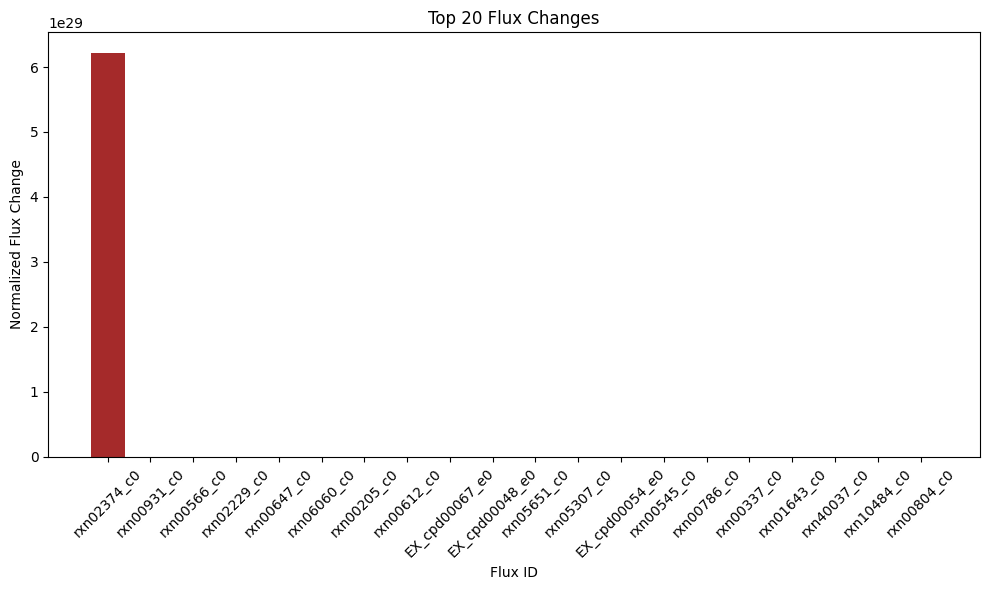

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 25f1e3b2-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:33
Completed in 0.066821 seconds
Set Exchange for Pyridoxal_e0 as zero. Flux ID: EX_cpd00215_e0
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00132_e0: -994.7738930702296
EX_cpd00023_e0: -741.630028473323
EX_cpd00027_e0: -563.1088069548878
EX_cpd00033_e0: -306.9713450328153
EX_cpd00007_e0: -209.41237626732632
EX_cpd00009_e0: -63.82618673815166
EX_cpd00107_e0: -29.486378559216636
EX_cpd00156_e0: -27.66752721274058
EX_cpd00142_e0: -26.90019921975526
EX_cpd00039_e0: -22.42084063636752
EX_cpd00051_e0: -19.377762422071196
EX_cpd00322_e0: -18.993005406470512
EX_cpd00054_e0: -16.542530314218297
EX_cpd00129_e0: -14.480854950789103
EX_cpd00066_e0: -12.137334946676337
EX_cpd00060_e0: -10.038660316127144
EX_cpd03847_e0: -9.822773864064747
EX_cpd01080_e0: -9.785729516117355
EX_cpd00069_e0: -9.699434444597827
EX_cpd00084_e0: -6.86290548353411
EX_cpd00119_e0: -6.226068070629362
EX_cpd00065_e0: -3.707658513970292
EX

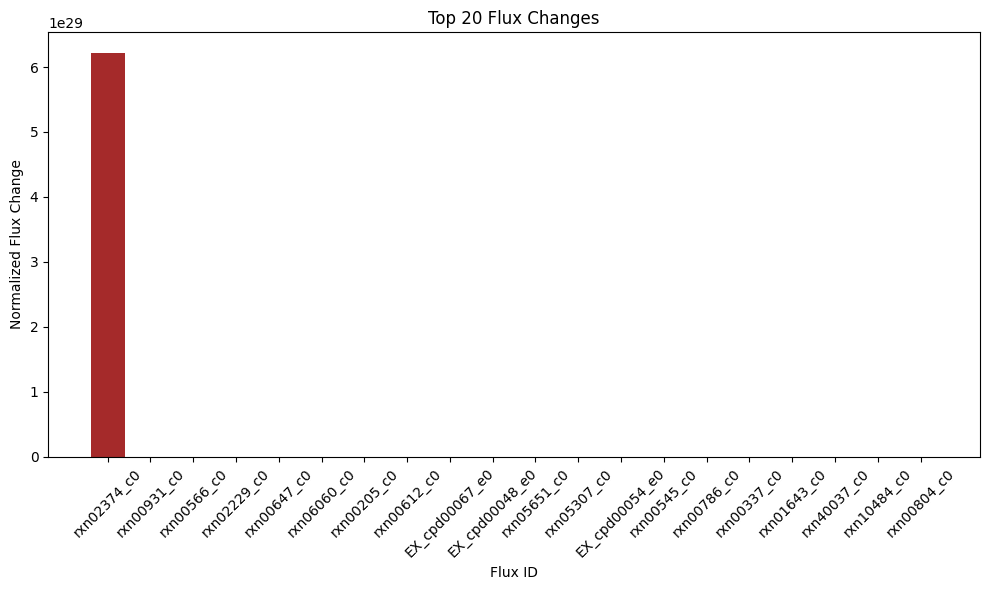

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 26cae824-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:34
Completed in 0.042180 seconds
Set Exchange for Mn2+_e0 as zero. Flux ID: EX_cpd00030_e0
Number of Uptake Fluxes: 4

Uptake Fluxes:
EX_cpd00033_e0: -1.4761506276150624
EX_cpd00027_e0: -0.527196652719665
EX_cpd00054_e0: -0.15815899581589965
EX_cpd00067_e0: -0.10543933054393466
Number of Secretion Fluxes: 4

Secretion Fluxes:
EX_cpd00075_e0: 0.15815899581589962
EX_cpd00001_e0: 0.4744769874476987
EX_cpd00047_e0: 0.6853556485355647
EX_cpd00161_e0: 1.4761506276150627
Objective flux for when eliminate 'EX_cpd00030_e0' (Exchange for Mn2+_e0): 0.0


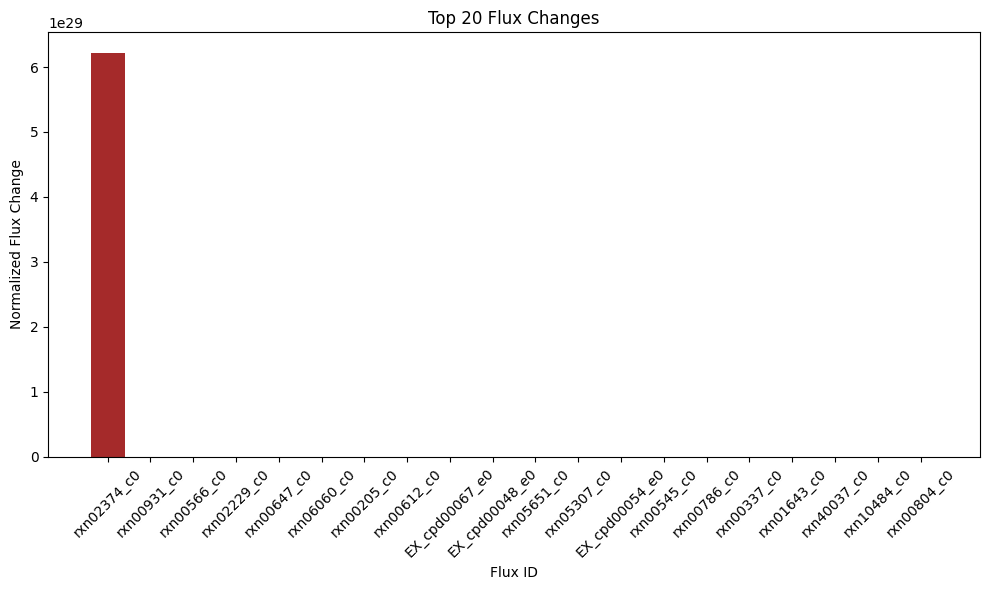

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 27a64d9c-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:36
Completed in 0.065231 seconds
Set Exchange for L-Phenylalanine_e0 as zero. Flux ID: EX_cpd00066_e0
Number of Uptake Fluxes: 38

Uptake Fluxes:
EX_cpd00132_e0: -983.1739049303369
EX_cpd00023_e0: -723.6278416033143
EX_cpd00027_e0: -579.2321722695017
EX_cpd00007_e0: -219.87467881133074
EX_cpd00033_e0: -194.36537278008336
EX_cpd00009_e0: -61.85095637325568
EX_cpd00107_e0: -28.57386297185439
EX_cpd00156_e0: -26.8112996568645
EX_cpd00142_e0: -26.067718179675015
EX_cpd00039_e0: -21.726982402086147
EX_cpd00051_e0: -18.778078394314754
EX_cpd00322_e0: -18.40522846229768
EX_cpd00054_e0: -16.03058827508924
EX_cpd00129_e0: -14.032715623188132
EX_cpd00060_e0: -9.727993680809272
EX_cpd03847_e0: -9.518788271392095
EX_cpd01080_e0: -9.482890335672229
EX_cpd00069_e0: -9.399265839575042
EX_cpd00084_e0: -6.650519000882741
EX_cpd00119_e0: -6.033389809003644
EX_cpd00065_e0: -3.5929175267100337
EX_cpd00220_e0: -0.640797997826

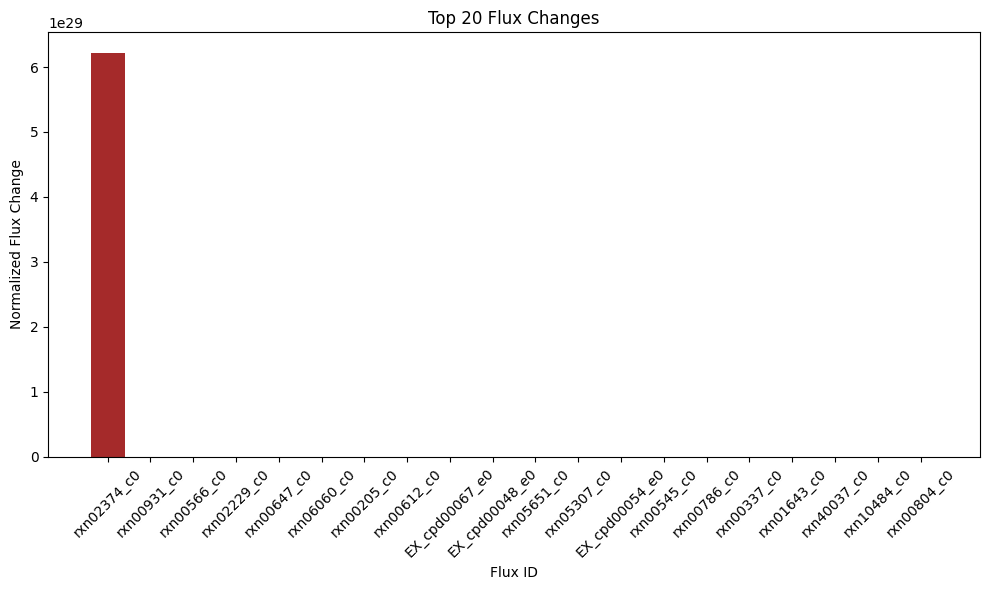

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 287b479a-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:37
Completed in 0.072115 seconds
Set Exchange for Nitrite_e0 as zero. Flux ID: EX_cpd00075_e0
Number of Uptake Fluxes: 41

Uptake Fluxes:
EX_cpd00027_e0: -719.7087424388113
EX_cpd00041_e0: -411.7755840251538
EX_cpd00132_e0: -401.60788233830476
EX_cpd00007_e0: -240.6251285828483
EX_cpd00033_e0: -63.194911942451334
EX_cpd00009_e0: -61.435330092976486
EX_cpd00023_e0: -42.60232975715964
EX_cpd00107_e0: -28.381852224131247
EX_cpd00156_e0: -26.631132988479028
EX_cpd00142_e0: -25.468220258707326
EX_cpd00039_e0: -21.580981347174482
EX_cpd00051_e0: -18.65189339521793
EX_cpd00322_e0: -18.28154894152231
EX_cpd00161_e0: -15.958479186521977
EX_cpd00054_e0: -15.922865870030686
EX_cpd00129_e0: -13.938418530000394
EX_cpd00066_e0: -11.682684130217702
EX_cpd00060_e0: -9.662623473695877
EX_cpd03847_e0: -9.454823883545567
EX_cpd01080_e0: -9.419167174903855
EX_cpd00069_e0: -9.336104618997936
EX_cpd00084_e0: -6.605828819252088

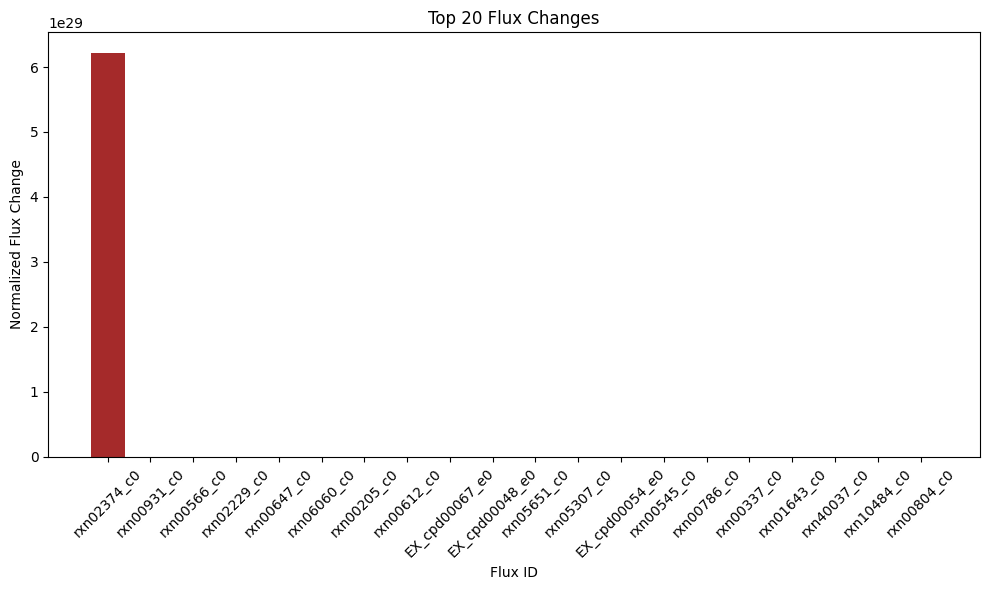

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 298874dc-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:39
Completed in 0.068169 seconds
Set Exchange for H2O_e0 as zero. Flux ID: EX_cpd00001_e0
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00023_e0: -708.8146979597425
EX_cpd00041_e0: -644.6471374647728
EX_cpd00132_e0: -355.2710561638442
EX_cpd00007_e0: -205.7220027092586
EX_cpd00027_e0: -171.34118469004034
EX_cpd00033_e0: -26.601855771906585
EX_cpd00009_e0: -25.861160973226756
EX_cpd00107_e0: -11.947321646613812
EX_cpd00156_e0: -11.210357559278181
EX_cpd00142_e0: -10.899450802036514
EX_cpd00039_e0: -9.08449961504085
EX_cpd00322_e0: -7.69560575813915
EX_cpd00161_e0: -6.717711103790042
EX_cpd00129_e0: -5.867367926095034
EX_cpd00066_e0: -4.917818044335688
EX_cpd00060_e0: -4.067474866640768
EX_cpd03847_e0: -3.9800017686217717
EX_cpd01080_e0: -3.9649921010483906
EX_cpd00069_e0: -3.930026973883289
EX_cpd00084_e0: -2.7807192082751544
EX_cpd00119_e0: -2.5226847604949647
EX_cpd00065_e0: -1.5022729472610454
EX_cp

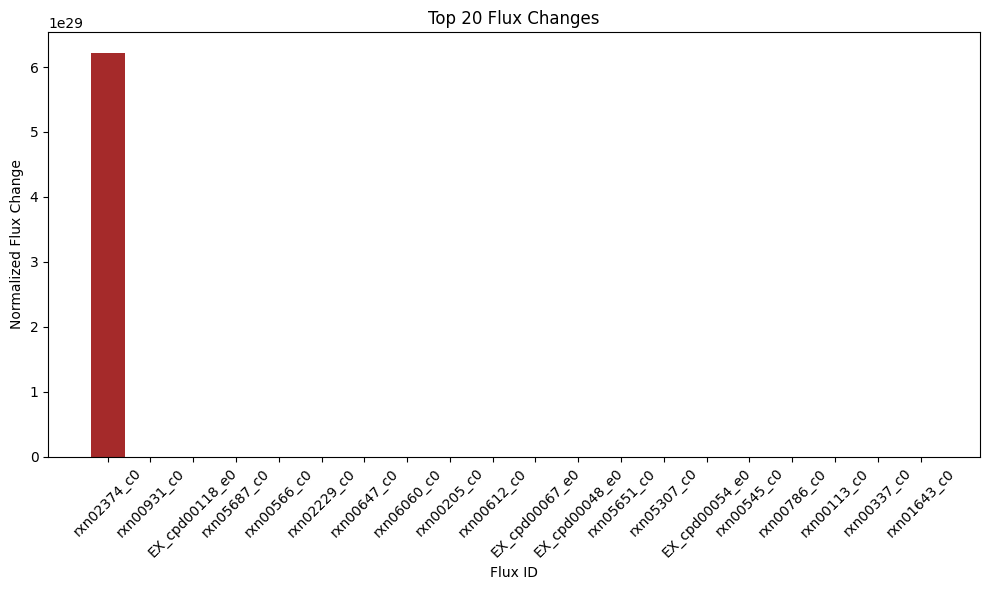

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 2a5c5b44-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:40
Completed in 0.065496 seconds
Set Exchange for Cbl_e0 as zero. Flux ID: EX_cpd00635_e0
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00132_e0: -994.7738930702296
EX_cpd00023_e0: -741.630028473323
EX_cpd00027_e0: -563.1088069548878
EX_cpd00033_e0: -306.9713450328153
EX_cpd00007_e0: -209.41237626732632
EX_cpd00009_e0: -63.82618673815166
EX_cpd00107_e0: -29.486378559216636
EX_cpd00156_e0: -27.66752721274058
EX_cpd00142_e0: -26.90019921975526
EX_cpd00039_e0: -22.42084063636752
EX_cpd00051_e0: -19.377762422071196
EX_cpd00322_e0: -18.993005406470512
EX_cpd00054_e0: -16.542530314218297
EX_cpd00129_e0: -14.480854950789103
EX_cpd00066_e0: -12.137334946676337
EX_cpd00060_e0: -10.038660316127144
EX_cpd03847_e0: -9.822773864064747
EX_cpd01080_e0: -9.785729516117355
EX_cpd00069_e0: -9.699434444597827
EX_cpd00084_e0: -6.86290548353411
EX_cpd00119_e0: -6.226068070629362
EX_cpd00065_e0: -3.707658513970292
EX_cpd00

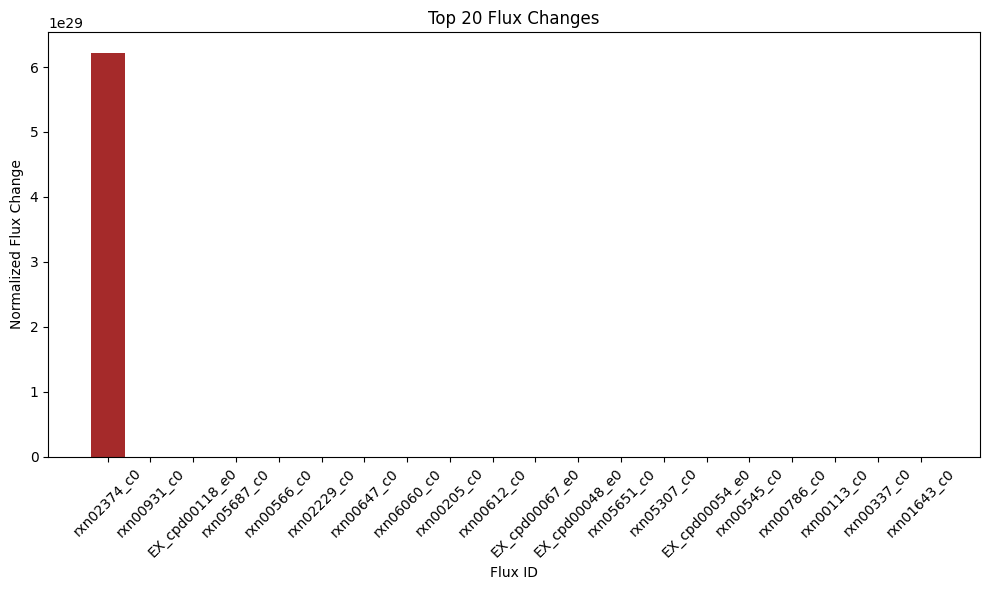

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 2b31d576-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:42
Completed in 0.065056 seconds
Set Exchange for L-Glutamate_e0 as zero. Flux ID: EX_cpd00023_e0
Number of Uptake Fluxes: 40

Uptake Fluxes:
EX_cpd00041_e0: -741.6300284733227
EX_cpd00027_e0: -563.1088069548706
EX_cpd00033_e0: -306.9713450328368
EX_cpd00132_e0: -253.1438645969112
EX_cpd00007_e0: -209.41237626732487
EX_cpd00009_e0: -63.82618673816111
EX_cpd00053_e0: -44.70111069504921
EX_cpd00107_e0: -29.486378559217155
EX_cpd00156_e0: -27.667527212741064
EX_cpd00142_e0: -26.900199219755713
EX_cpd00039_e0: -22.420840636367913
EX_cpd00051_e0: -19.377762422071537
EX_cpd00322_e0: -18.993005406470765
EX_cpd00054_e0: -16.542530314218585
EX_cpd00129_e0: -14.480854950789896
EX_cpd00066_e0: -12.13733494667655
EX_cpd00060_e0: -10.038660316127146
EX_cpd03847_e0: -9.822773864064924
EX_cpd01080_e0: -9.785729516117527
EX_cpd00069_e0: -9.699434444597996
EX_cpd00084_e0: -6.862905483534902
EX_cpd00119_e0: -6.226068070629

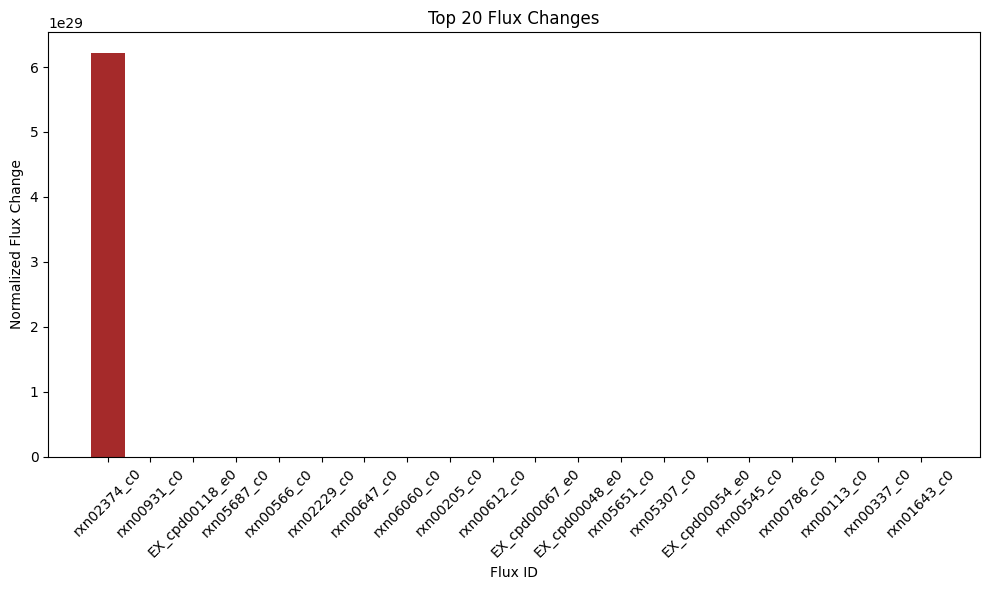

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 2c06c812-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:43
Completed in 0.042256 seconds
Set Exchange for Zn2+_e0 as zero. Flux ID: EX_cpd00034_e0
Number of Uptake Fluxes: 4

Uptake Fluxes:
EX_cpd00033_e0: -1.4761506276150624
EX_cpd00027_e0: -0.527196652719665
EX_cpd00054_e0: -0.15815899581589965
EX_cpd00067_e0: -0.10543933054393466
Number of Secretion Fluxes: 4

Secretion Fluxes:
EX_cpd00075_e0: 0.15815899581589962
EX_cpd00001_e0: 0.4744769874476987
EX_cpd00047_e0: 0.6853556485355647
EX_cpd00161_e0: 1.4761506276150627
Objective flux for when eliminate 'EX_cpd00034_e0' (Exchange for Zn2+_e0): 0.0


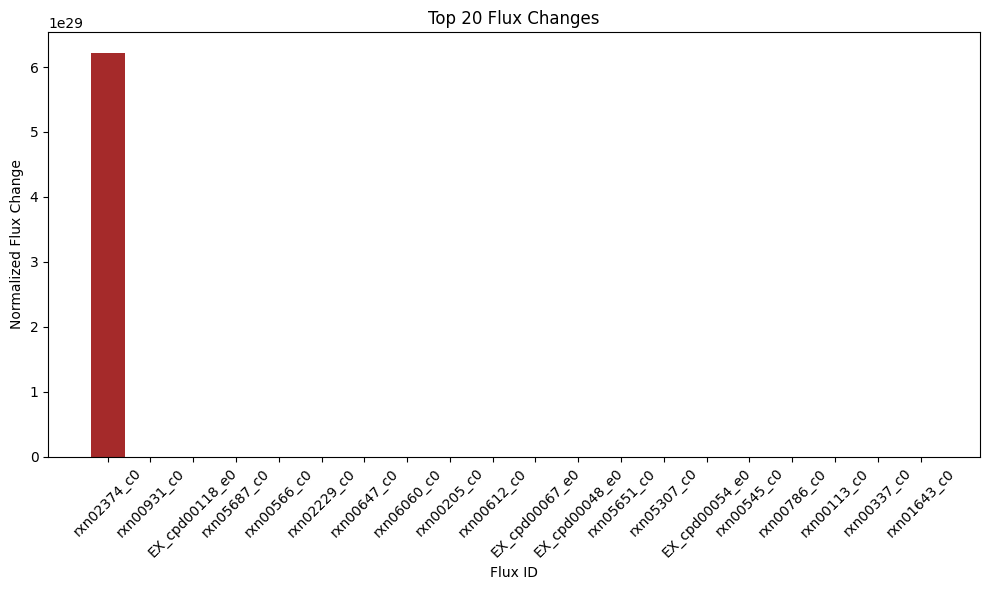

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 2cd7df9c-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:44
Completed in 0.071849 seconds
Set Exchange for L-Threonine_e0 as zero. Flux ID: EX_cpd00161_e0
Number of Uptake Fluxes: 41

Uptake Fluxes:
EX_cpd00041_e0: -809.5650618287079
EX_cpd00027_e0: -563.1088069549678
EX_cpd00007_e0: -321.7811611919515
EX_cpd00132_e0: -185.20883124152883
EX_cpd00053_e0: -112.63614405000288
EX_cpd00033_e0: -82.23377518290374
EX_cpd00009_e0: -63.82618673815871
EX_cpd00107_e0: -29.48637855920272
EX_cpd00156_e0: -27.66752721272752
EX_cpd00142_e0: -26.900199219734656
EX_cpd00039_e0: -22.420840636398268
EX_cpd00051_e0: -19.37776242206205
EX_cpd00322_e0: -18.99300540646155
EX_cpd00054_e0: -16.542530314210488
EX_cpd00129_e0: -14.480854950766807
EX_cpd00066_e0: -12.137334946670608
EX_cpd00060_e0: -10.03866031612221
EX_cpd03847_e0: -9.822773864064414
EX_cpd01080_e0: -9.785729516121826
EX_cpd00069_e0: -9.699434444592262
EX_cpd00084_e0: -6.862905483525933
EX_cpd00119_e0: -6.226068070632309

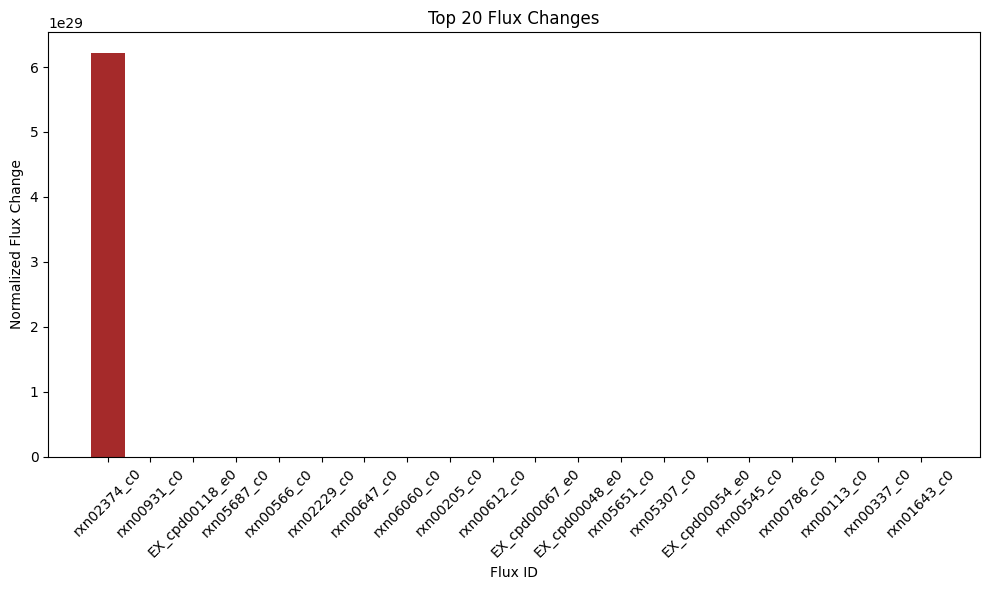

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 2de6d7a8-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:46
Completed in 0.041940 seconds
Set Exchange for Co2+_e0 as zero. Flux ID: EX_cpd00149_e0
Number of Uptake Fluxes: 4

Uptake Fluxes:
EX_cpd00033_e0: -1.4761506276150624
EX_cpd00027_e0: -0.527196652719665
EX_cpd00054_e0: -0.15815899581589965
EX_cpd00067_e0: -0.10543933054393466
Number of Secretion Fluxes: 4

Secretion Fluxes:
EX_cpd00075_e0: 0.15815899581589962
EX_cpd00001_e0: 0.4744769874476987
EX_cpd00047_e0: 0.6853556485355647
EX_cpd00161_e0: 1.4761506276150627
Objective flux for when eliminate 'EX_cpd00149_e0' (Exchange for Co2+_e0): 0.0


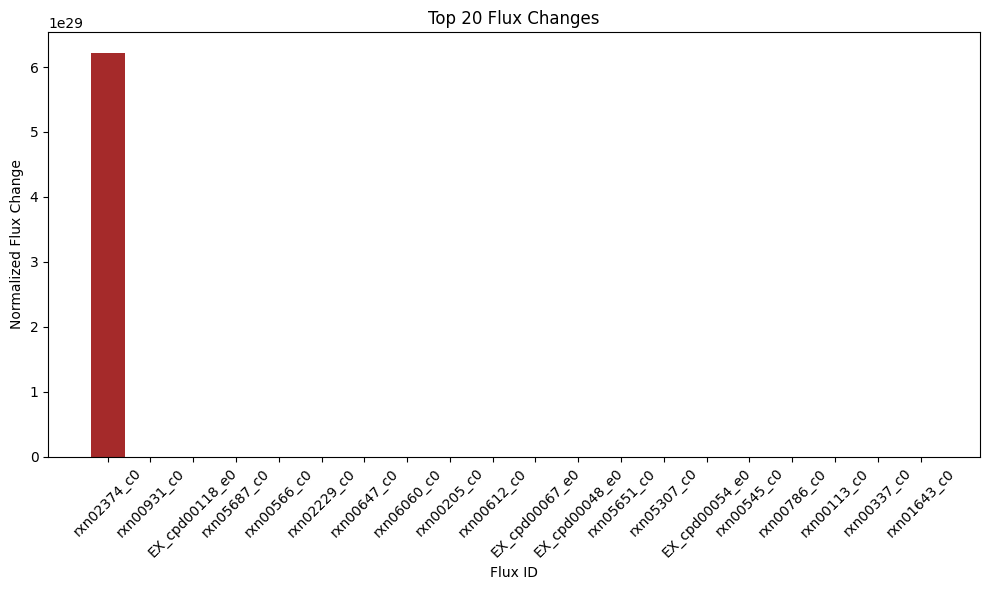

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 2eb6be1e-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:47
Completed in 0.071155 seconds
Set Exchange for Glycine_e0 as zero. Flux ID: EX_cpd00033_e0
Number of Uptake Fluxes: 39

Uptake Fluxes:
EX_cpd00041_e0: -979.6952753999956
EX_cpd00027_e0: -618.3105193056468
EX_cpd00053_e0: -389.56502224610716
EX_cpd00007_e0: -255.10353118697944
EX_cpd00048_e0: -63.690193307419555
EX_cpd00009_e0: -61.70964347696727
EX_cpd00107_e0: -28.50857933565321
EX_cpd00156_e0: -26.750043006526113
EX_cpd00142_e0: -26.00816041417714
EX_cpd00039_e0: -21.677342057121784
EX_cpd00051_e0: -18.735175506467222
EX_cpd00322_e0: -18.363177436844328
EX_cpd00161_e0: -16.029735000118382
EX_cpd00054_e0: -15.993962667481592
EX_cpd00132_e0: -15.251920854542824
EX_cpd00129_e0: -14.000654620339198
EX_cpd00066_e0: -11.734848196289018
EX_cpd00060_e0: -9.70576781652715
EX_cpd03847_e0: -9.497040385528784
EX_cpd01080_e0: -9.461224466992883
EX_cpd00069_e0: -9.377791030507964
EX_cpd00119_e0: -6.019605126626333

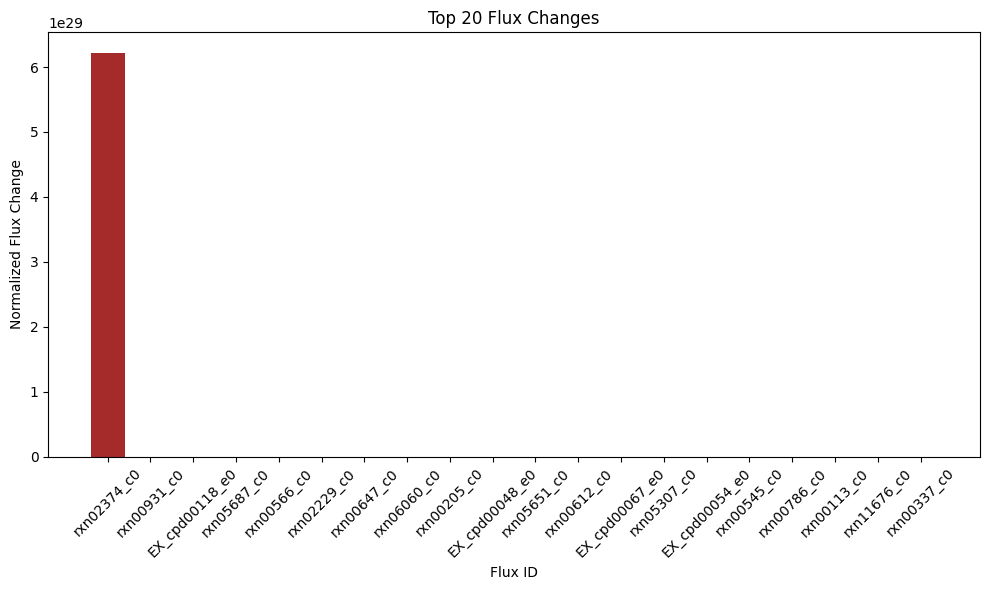

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.



Simulation ID: 2f8fc1b4-9973-11ee-a531-ba21c95c07d9
Created: 12/12/2023 at 23:50:49
Completed in 0.064281 seconds
Set Exchange for L-Methionine_e0 as zero. Flux ID: EX_cpd00060_e0
Number of Uptake Fluxes: 38

Uptake Fluxes:
EX_cpd00132_e0: -994.8109087739144
EX_cpd00023_e0: -743.5536133565186
EX_cpd00027_e0: -563.1675679477755
EX_cpd00033_e0: -245.69137678305478
EX_cpd00007_e0: -212.133134512663
EX_cpd00009_e0: -63.37411577063648
EX_cpd00107_e0: -29.277531119560873
EX_cpd00156_e0: -27.47156241467687
EX_cpd00142_e0: -26.709669286688246
EX_cpd00039_e0: -22.262037304434728
EX_cpd00051_e0: -19.24051274049434
EX_cpd00322_e0: -18.85848089907659
EX_cpd00054_e0: -16.42536214130707
EX_cpd00129_e0: -14.378289304267868
EX_cpd00066_e0: -12.051368088360144
EX_cpd00084_e0: -10.280531437920912
EX_cpd03847_e0: -9.753200682410458
EX_cpd01080_e0: -9.716418713826034
EX_cpd00069_e0: -9.630734856895153
EX_cpd00048_e0: -6.7201826873070045
EX_cpd00119_e0: -6.181969797487338
EX_cpd00065_e0: -3.68139774457111

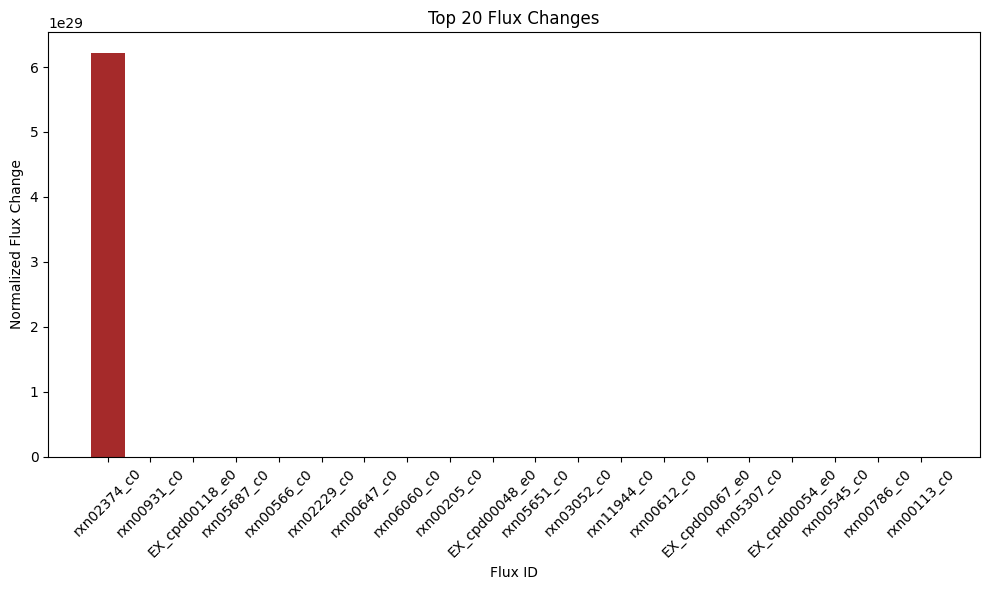

In [300]:
# Call the main loop
main_loop(model_path, bound_exchange_fluxes_dict, name_exchange_fluxes_dict, ex_output_folder)

## Model Topology. 
#### The model compute the FBA and provide the optimized Fluxes, the Objective flux and the reactions. 

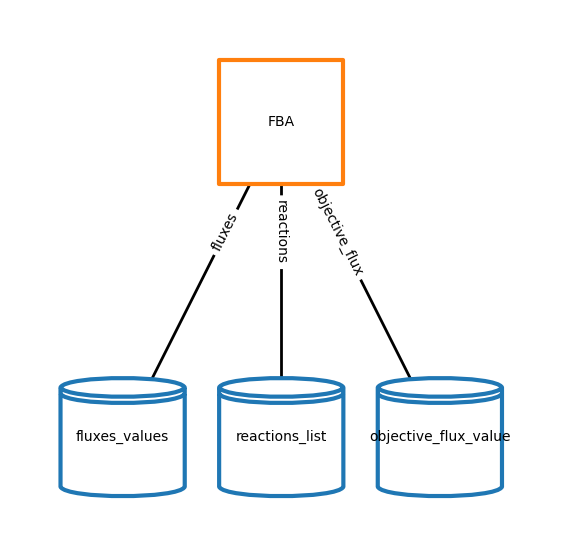

In [29]:
composite = {'processes' : processes , 'topology' : topology , 'steps' : {}, 'flow' : {}}
config ={'font_size' : 10}
fig_topology = plot_topology(composite, config)
